In [354]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.colors
import matplotlib
#from sklearn.manifold import TSNE
import time
import energyflow as ef
from scipy import stats
import pandas as pd
import seaborn as sns
import math
import pickle
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import grad
from torch.utils.data import DataLoader

# from geomloss import SamplesLoss
import dcor

import sys 
sys.path.append('..')   # to import from parent folder

# import custom libraries
import myFunctions as myF
import myPlots as myP
import models as models
import transformer_models as t_models
import transformer_modules
import loss_functions as lossF
import PID as PID
from dataset import NPY_Dataset, Dataset_Bucketing, Dataset_Bucketing_2
import energyflow_torch as efT
import jetnet
import utils
import evaluation_metrics as eval

# reload custom libraries
import importlib
importlib.reload(myF)
importlib.reload(myP)
importlib.reload(models)
importlib.reload(t_models)
importlib.reload(transformer_modules)
importlib.reload(lossF)
importlib.reload(PID)
importlib.reload(efT)
importlib.reload(utils)
importlib.reload(eval)

print('imports done')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device: ',device)

# to make plots show up even when matplotlib.use('agg') in one of the imports:
%matplotlib inline    

imports done
device:  cuda


In [355]:
# parameters
params = {}
#epochs = 400
equiv_layers = 6   # number of equivariant layers
latent = 10       # global latent space before: 64, afterwards 128
#index = 0
rand = 95694

dataset_type = 'jetnet_top'   # 'jetnet_quark' / 'jetnet_top' / 'jetnet_gluon' / 'jetnet_gluon_notCentered'
jet_type = 't'   # for FPND calculation
n_points_cut = 150   # max: 148
GAN_type = 'LSGAN'   # LSGAN or GAN
hid_d = 128         # hidden dimensionality (default 128)
latent_local = 3  #local latent space : 64, afterwards 32

folder_name = '/beegfs/desy/user/buhmae/2_PointCloudGeneration/220727_GANscan/'

normalize_points = True # normalize points with mean=0 and std=1
# params['normalize_points_forDiscrOnly'] = False   # default: False  # not needed in evaluation
norm_sigma = 5    # scaling of stds in normalization
center_gen = True

plot_mpgan = False
generator_name = 'EPiC-GAN'
dataset_name = 'JetNet'+str(n_points_cut)
color_list = ['grey', 'crimson', 'royalblue']

save_plots = True
pdf_folder = './output/plots/'+generator_name+'_'+dataset_type+str(n_points_cut)+'_el'+str(equiv_layers)+'_l'+str(latent)+'_'+str(rand)+'/'


## define name of save file
model_name = 'Dec_GAN_EPiC_res_weight_norm_addSampledNoise_orderGlobalLocal__Discr_DeepSets_Res_LReLU_weight_norm_meansumpool_wEPiClayers_fixed'  # 3 EPiC layers FIXED!!
# model_name = 'Dec_GAN_EPiC_res_weight_norm_addSampledNoise_orderGlobalLocal__Discr_DeepSets_Res_3and3layer_LReLU_weight_norm_mixNOmax_NOcond'
# model_name = 'Dec_GAN_EPiC_res_weight_norm_orderGlobalLocal_REUSE__Discr_DeepSets_Res_3and3layer_LReLU_weight_norm_mixNOmax_NOcond'

# model_name = 'Dec_GAN_MultipleParticles_GlobalEquivX_res_weight_norm_addSampledNoise_sameGlobalLocalFC__Discr_DeepSets_Res_LReLU_weight_norm_meansumpool_wEPiClayers'
# model_name = 'Dec_GAN_MultipleParticles_GlobalEquivX_res_weight_norm_addSampledNoise_sameGlobalLocalFC_sigtanh_lastLnoWN__Discr_DeepSets_Res_3and3layer_LReLU_weight_norm_mixNOmax_NOcond'
# model_name = 'Dec_GAN_MultipleParticles_GlobalEquivX_res_weight_norm_addSampledNoise_sameGlobalLocalFC_sigtanh__Discr_DeepSets_Res_3and3layer_LReLU_weight_norm_mixNOmax_NOcond'
# model_name = 'Dec_GAN_MultipleParticles_GlobalEquivX_res_weight_norm_sameGlobalLocalFC_REUSEeqLAYER__Discr_DeepSets_Res_3and3layer_LReLU_weight_norm_mixNOmax_NOcond'
# model_name = 'Dec_GAN_MultipleParticles_GlobalEquivX_res_weight_norm_sameGlobalLocalFC__Discr_DeepSets_Res_3and3layer_LReLU_weight_norm_mixNOmax_NOcond'
# model_name = 'Dec_GAN_MultipleParticles_GlobalEquivX_res_weight_norm_addSampledNoise_sameGlobalLocalFC__Discr_DeepSets_Res_3and3layer_LReLU_weight_norm_mixNOmax_NOcond'
# model_name = 'Dec_GAN_MultipleParticles_GlobalEquivX_res_weight_norm_addSampledNoise_noOneHot_mixNOmax_NOcond_LReLU__Discr_DeepSets_Res_3and3layer_LReLU_weight_norm_mixNOmax_NOcond'
#save_file_name = model_name+'_el'+str(equiv_layers)+'_l'+str(latent)+'_'+str(rand)
save_file_name = GAN_type+'_'+model_name+'_el'+str(equiv_layers)+'_l'+str(latent)+'_'+str(rand)

tmp_save_file = save_file_name

#######################################   
params['norm_sigma'] = norm_sigma  
params['n_points_cut'] = n_points_cut
params['dataset_type'] = dataset_type
#######################################   
                  
save_interval = 200
batch_size = 128      # mostly used 128
batch_size_max = 512
batch_size_max_val = 2048

no_cond_feats = 5  # amount of conditioned on features
n_channels = 128    # channels in CNN
feats = 3
reduce_lr_after_Xepochs = 100   # for basic learning rate scheduler

#pad_value = -0.6   # change zero padding to this value (should be max -3)
pt_scaling = 1.   # scale input pt by this value for training
y_scaling = 1.
phi_scaling = 1.
pt_log_scaling = False
shuffle_points_train = False   # currently doesn't change anything (all Conv1 net)
shuffle_points_test = False    # changes the per particle plotting & KDE sampling kernel
order_points_pt = True       # pt ordering of particles (for test & gen set)     
minmax_scale = False    # scale points with minimum and max value to range [0,1]
use_p3s = False     # using 3-vector notation  (here fully implemented)
scale_p3s = 1e-2   # scale input data points with this factor (p3s * scale_p3s)

#beta_C0 = 0.
#lambda_gp = 100.0
beta_reco = 5000.   # mostly at 10    # 200
beta_EMD = 10.
beta_reco_cond = 0.001
beta_KLD_global = 0.5   # 10
beta_KLD_local = 0    # 100
beta_C = 1.          # discriminator loss weight
KLD_pow = 2    # exponen for KLD_pow
beta_mean_std = 0.1
beta_C_singleP = 10
beta_ptMSE = 0.01

lr = 1e-4     # default: 0.75e-3
lr_C = 1e-4  
beta1 = 0.9     # adam optimizer paramter , default: 0.9, usually set to: 0.5 for GANs

# learning rate scheduler
enable_scheduler = False
s_factor = 0.75
cooldown = 50
patience = 20    # was not used until now
opti_reset = True
opti_reset_epochs = 20

# adaptive KLD weights
enable_PIDcontrol = False
target_KLD_global = 30.   # with PIDcontrol - default: 3 - mostly 6.
target_KLD_local = 6.   # default: 0.1 - recently mostly 6.
Kp = 0.01    # default in paper / github: 0.001
Ki = -0.001   # default in github: -0.0001 (but I increased it to adjust beta faster)
Kd = 0.0
#reco_PID_min_start = 0.05      # minimum loss reco before PID control starts
ep_PID_min_start = 2          # after this epoch the PID control starts

# GAN STUFF
# Establish convention for real and fake labels during training
real_label = 1.    # usually 1, but slightly lower might stabelize training "one-sided label smoothing"
fake_label = 0.
lambda_gp = 1

In [356]:
# initiate data lodaer
######## initiate data lodaer
f_train, f_test, f_val, f_kde, norm_means, norm_stds, mins, maxs = utils.get_dataset(params)


In [357]:
importlib.reload(models)
importlib.reload(transformer_modules)
importlib.reload(t_models)
importlib.reload(myF)
importlib.reload(lossF)
importlib.reload(PID)
importlib.reload(efT)

# define model, loss

## arguments for network
args = {'latent': latent,
        'latent_local': latent_local,
        'no_cond_feats': no_cond_feats,
        'device': device,
        'n_points': n_points_cut,
        'hid_d': hid_d,
        'n_channels': n_channels,
        'feats': feats,
        'VAE_reparam': True,
        'equiv_layers': equiv_layers,
        'return_latent_space': True,
        'norm_means': norm_means,
        'norm_stds': norm_stds,
        'norm_sigma': params['norm_sigma'],
        'mins': mins,
        'maxs': maxs}

# lodels
C, D = utils.get_model(model_name=model_name, args=args, latent=latent)


# reset iterations
iteration = 0
epoch = 0
best_epoch = 0
best_w_dist_ms = 0
test_w_dist_ms = 0

epoch_list, iteration_list = [], []
loss_reco_list, loss_reco_cond_list = [], []
loss_KLD_global_list = []
loss_KLD_local_list = []
loss_tot_list = []
beta_KLD_global_list = []
beta_KLD_local_list =  []
loss_C_list = []
errD_list = []
out_ms_max_list = []


## GAN SPECIFIC STUFF
# criterion_BCE = nn.BCEWithLogitsLoss()  # when no sigmoid in last layer

print('model initiated')

# Model size
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# print('Encoder parameters: ', count_parameters(E))
print('Decoder parameters: ', count_parameters(D))
print('Discriminator parameters: ', count_parameters(C))
# print('Local Encoder parameters: ', count_parameters(E_local))

model initiated
Decoder parameters:  424850
Discriminator parameters:  313170


In [358]:
# load model
load = True
#folder = '/beegfs/desy/user/buhmae/2_PointCloudGeneration/tmp_trainings/'
#tmp_save_file = 'tmpqg51_1.tar'
#path = folder+tmp_save_file+'.tar'
path = folder_name+tmp_save_file+'.tar'
path = folder_name+tmp_save_file + '_best_model'  +'.tar'
# path = folder_name+tmp_save_file + '_best_model_fpnd'  +'.tar'

if load == True:
    checkpoint = torch.load(path)
    #E.load_state_dict(checkpoint['encoder_state'], strict=True)
    #E_local.load_state_dict(checkpoint['local_encoder_state'], strict=True)
    D.load_state_dict(checkpoint['decoder_state'], strict=True)
    #C.load_state_dict(checkpoint['discr_state'], strict=True)
    #optimizer_E.load_state_dict(checkpoint['optimizer_E_state'])
    #optimizer_E_local.load_state_dict(checkpoint['optimizer_E_local_state'])
    #optimizer_D.load_state_dict(checkpoint['optimizer_D_state'])
    #optimizer_C.load_state_dict(checkpoint['optimizer_C_state'])
    #scheduler_E.load_state_dict(checkpoint['scheduler_E_state'])
    #scheduler_D.load_state_dict(checkpoint['scheduler_D_state'])

    # set to eval mode
    #E.eval()
    #E_local.eval()
    D.eval()
    C.eval()
    print('model loaded from ', path)

    #n_points = 5

model loaded from  /beegfs/desy/user/buhmae/2_PointCloudGeneration/220727_GANscan/LSGAN_Dec_GAN_EPiC_res_weight_norm_addSampledNoise_orderGlobalLocal__Discr_DeepSets_Res_LReLU_weight_norm_meansumpool_wEPiClayers_fixed_el6_l10_95694_best_model.tar


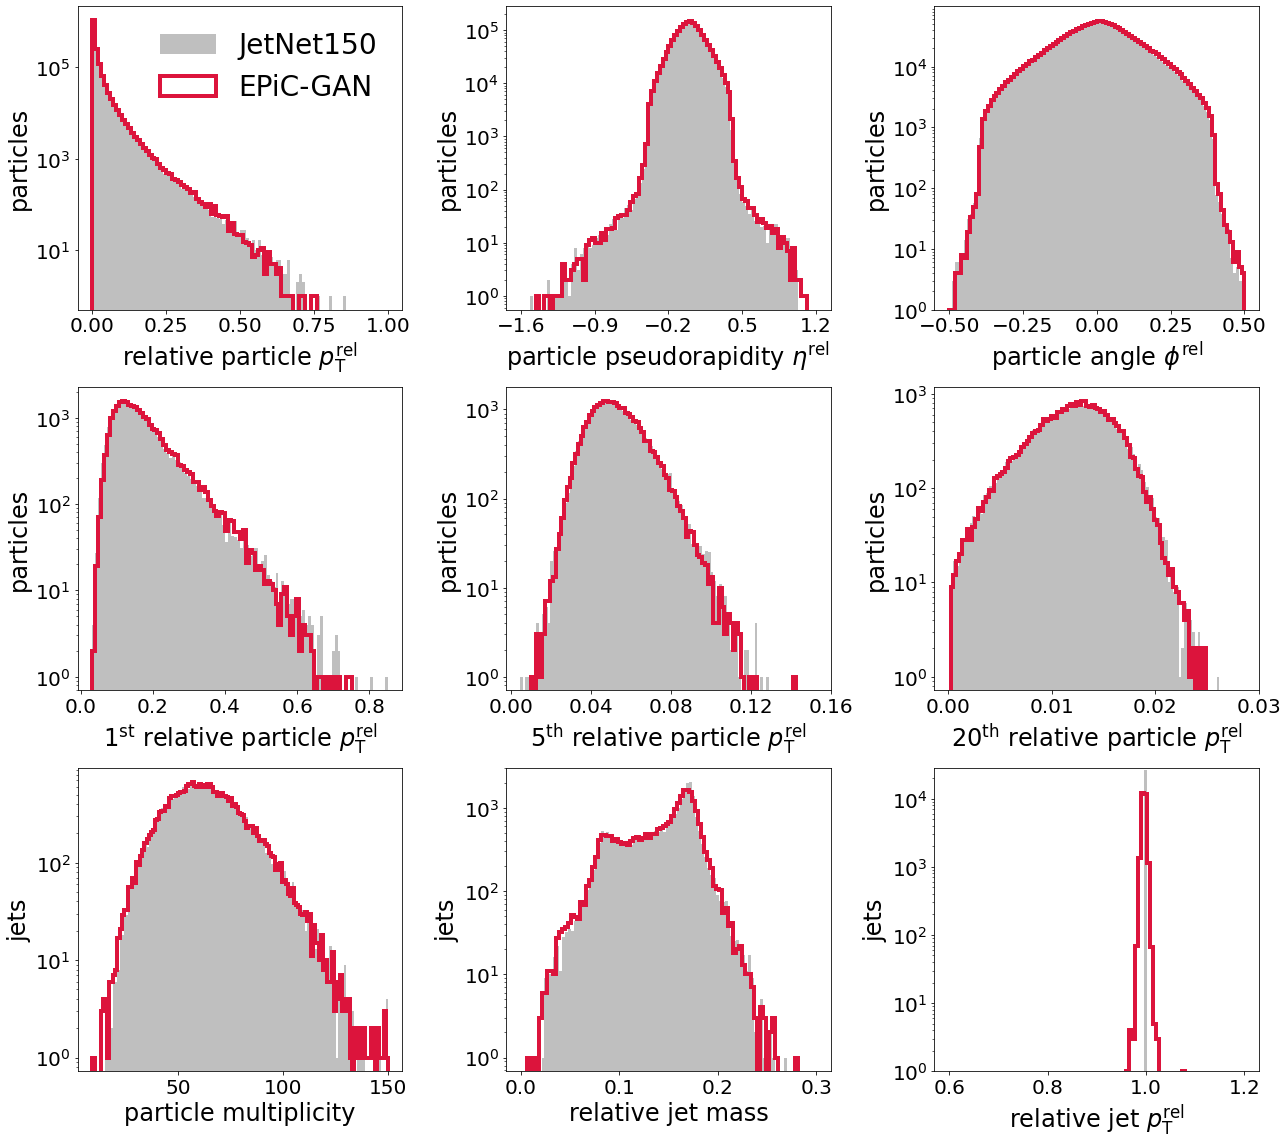

In [359]:
fig = utils.plot_overview(D, f_test, f_kde, latent, latent_local, norm_means, norm_stds, norm_sigma, normalize_points=normalize_points, set_min_pt=True, min_pt = mins[0], return_latent_space = args['return_latent_space'], center_gen=center_gen)

In [360]:
# evaluation loop

s_time = time.time()
data_test_ary, reco_ary, latent_np = utils.evaluation_loop(D, f_test, f_kde, latent, latent_local, norm_means, norm_stds, norm_sigma, normalize_points, return_latent_space = args['return_latent_space'], gen_size_same_as_data=False, 
                                                    order_points_pt=True, center_gen=center_gen, calibrate_pt=False)
print(time.time() - s_time)
print(data_test_ary.shape)
print(reco_ary.shape)

reco_test_ary = reco_ary[:len(data_test_ary)]
print(reco_test_ary.shape)

14.064774751663208
(26692, 150, 3)
(299982, 150, 3)
(26692, 150, 3)


In [361]:
## save generated jets
# f_save = '/beegfs/desy/user/buhmae/forCedric/221116_EPiC-GAN_JetNet150_tops_hid128.npy'
# np.save(f_save, reco_test_ary)
# print('saved')

In [362]:
# load MPGAN quark generation output
if dataset_type == 'jetnet_quark':
    mpgan_file = '/home/buhmae/2_PointCloudGeneration/MPGAN/gen_jets_q_300k.npy'
elif (dataset_type == 'jetnet_gluon') or (dataset_type == 'jetnet_gluon_notCentered'):
    mpgan_file = '/home/buhmae/2_PointCloudGeneration/MPGAN/gen_jets_g_100k.npy'
elif dataset_type == 'jetnet_top':
    mpgan_file = '/home/buhmae/2_PointCloudGeneration/MPGAN/gen_jets_t_100k.npy'
else:
    print('no jetnet dataset type defined!')
    sys.exit()
gen_mpgan = np.load(mpgan_file)

gen_mpgan = gen_mpgan[:,:,[2,0,1]]

if order_points_pt == True:
    gen_mpgan = myF.order_ary(gen_mpgan, order_dim = 0)
    
# n max
gen_mpgan = gen_mpgan[0:data_test_ary.shape[0]]

center_gen_mpgan = False
if center_gen_mpgan:
    gen_mpgan = myF.center_jets(gen_mpgan)
    print('gen_mpgan centered')

print(mpgan_file)


/home/buhmae/2_PointCloudGeneration/MPGAN/gen_jets_t_100k.npy


In [363]:
%%time
# data variables
data_ms = myF.jet_masses(data_test_ary)
data_pts = myF.jet_pts(data_test_ary)
data_ys = myF.jet_ys(data_test_ary)
data_etas = myF.jet_etas(data_test_ary)
data_phis = myF.jet_phis(data_test_ary)
data_mults = myF.jet_mults(data_test_ary)
# reco variables
reco_ms = myF.jet_masses(reco_test_ary)
reco_pts = myF.jet_pts(reco_test_ary)
reco_ys = myF.jet_ys(reco_test_ary)
reco_etas = myF.jet_etas(reco_test_ary)
reco_phis = myF.jet_phis(reco_test_ary)
reco_mults = myF.jet_mults(reco_test_ary)
# MPGAN generation variables
gen_mpgan_ms = myF.jet_masses(gen_mpgan)
gen_mpgan_pts = myF.jet_pts(gen_mpgan)
gen_mpgan_ys = myF.jet_ys(gen_mpgan)
gen_mpgan_etas = myF.jet_etas(gen_mpgan)
gen_mpgan_phis = myF.jet_phis(gen_mpgan)
gen_mpgan_mults = myF.jet_mults(gen_mpgan)

CPU times: user 3.2 s, sys: 869 ms, total: 4.07 s
Wall time: 4.08 s


In [364]:
# recalibrate jet pt from relative pt
rel_pt = False
if rel_pt:
    data_test_ary[...,0] = data_test_ary[...,0] / data_pts.reshape(-1,1)
    reco_test_ary[...,0] = reco_test_ary[...,0] / reco_pts.reshape(-1,1)
    data_ms = myF.jet_masses(data_test_ary)
    reco_ms = myF.jet_masses(reco_test_ary)
    reco_pts = myF.jet_pts(reco_test_ary)
    data_pts = myF.jet_pts(data_test_ary)
    print('calculated with relative particle pt')

    # set negative pt values to minimum positive pt value
    remove_negative_pt = True
    if remove_negative_pt:
        #min_pt = reco_test_ary[...,0][reco_test_ary[...,0] > 0.0].min()
        #min_pt = data_test_ary[...,0][data_test_ary[...,0] > 0.0].min()
        min_pt = 0.00013
        #reco_test_ary[...,0][reco_test_ary[...,0] < min_pt] = min_pt
        reco_test_ary[...,0][(reco_test_ary[...,0] < min_pt) & (reco_test_ary[...,0] != 0.0)] = min_pt
        print(min_pt)
        
            # order particles by pt
        if order_points_pt == True:
            data_test_ary = myF.order_ary(data_test_ary, order_dim = 0)
            reco_test_ary = myF.order_ary(reco_test_ary, order_dim = 0)

In [365]:
data_mults.max()

150

In [366]:
# number of nans
np.count_nonzero(np.isnan(data_ys))

0

In [367]:
# # mask nans
# data_ms = data_ms[~np.isnan(data_ms)]
# data_pts = data_pts[~np.isnan(data_pts)]
# data_ys = data_ys[~np.isnan(data_ys)]
# data_etas = data_etas[~np.isnan(data_etas)]
# data_phis = data_phis[~np.isnan(data_phis)]
# data_mults = data_mults[~np.isnan(data_mults)]

# reco_ms = reco_ms[~np.isnan(reco_ms)]
# reco_pts = reco_pts[~np.isnan(reco_pts)]
# reco_ys = reco_ys[~np.isnan(reco_ys)]
# reco_etas = reco_etas[~np.isnan(reco_etas)]
# reco_phis = reco_phis[~np.isnan(reco_phis)]
# reco_mults = reco_mults[~np.isnan(reco_mults)]

In [368]:
# mask pt 
pt_cut = False
if pt_cut:

    n = 300000
    min_ms, max_ms = 20, 150    # GeV
    data_pt_mask = [(data_ms > min_ms) & (data_ms < max_ms)]
    reco_pt_mask = [(reco_ms > min_ms) & (reco_ms < max_ms)]

    data_test_ary = data_test_ary[ms_diff_mask][0:n]
    reco_test_ary = reco_test_ary[ms_diff_mask][0:n]

    data_ms = data_ms[ms_diff_mask][0:n]
    data_pts = data_pts[ms_diff_mask][0:n]
    data_ys = data_ys[ms_diff_mask][0:n]
    data_etas = data_etas[ms_diff_mask][0:n]
    data_phis = data_phis[ms_diff_mask][0:n]
    data_mults = data_mults[ms_diff_mask][0:n]

    reco_ms = reco_ms[ms_diff_mask][0:n]
    reco_pts = reco_pts[ms_diff_mask][0:n]
    reco_ys = reco_ys[ms_diff_mask][0:n]
    reco_etas = reco_etas[ms_diff_mask][0:n]
    reco_phis = reco_phis[ms_diff_mask][0:n]
    reco_mults = reco_mults[ms_diff_mask][0:n]

In [369]:
# calc p3s and p4s

data_test_ary_p3s = efT.torch_p3s_from_ptyphi(torch.tensor(data_test_ary)).numpy()
reco_test_ary_p3s = efT.torch_p3s_from_ptyphi(torch.tensor(reco_test_ary)).numpy()
gen_mpgan_p3s = efT.torch_p3s_from_ptyphi(torch.tensor(gen_mpgan)).numpy()

data_test_ary_p4s = efT.torch_p4s_from_ptyphi(torch.tensor(data_test_ary)).numpy()
reco_test_ary_p4s = efT.torch_p4s_from_ptyphi(torch.tensor(reco_test_ary)).numpy()
gen_mpgan_p4s = efT.torch_p4s_from_ptyphi(torch.tensor(gen_mpgan)).numpy()

In [370]:
print(data_test_ary.shape)
print(reco_test_ary.shape)
print(gen_mpgan.shape)

(26692, 150, 3)
(26692, 150, 3)
(26692, 30, 3)


<Figure size 432x288 with 0 Axes>

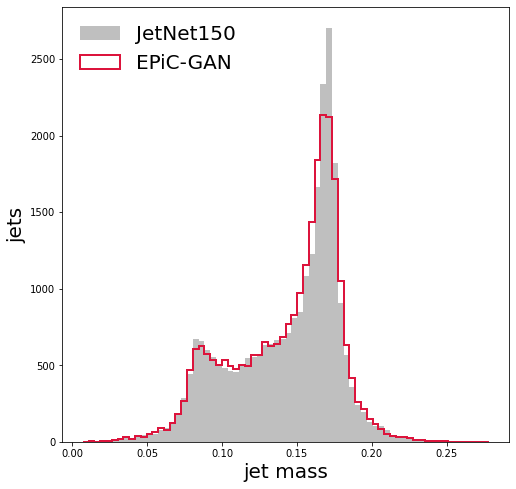

In [371]:
# plot jet level histograms
plt.clf()
plt.figure(figsize=(8,8), facecolor='none')
x_min, x_max = np.array([data_ms.min(), reco_ms.min()]).min(), np.array([data_ms.max(), reco_ms.max()]).max()
#x_min, x_max = 0, 0.5
hist1 = plt.hist(data_ms, bins=70, label=dataset_name, histtype='stepfilled', range=[x_min,x_max], alpha=0.5, color=color_list[0])
hist2 = plt.hist(reco_ms, bins=70, label=generator_name, histtype='step', range=[x_min,x_max], lw=2, color=color_list[1])
if plot_mpgan:
    hist2 = plt.hist(gen_mpgan_ms, bins=70, label='MP-GAN', histtype='step', range=[x_min,x_max], lw=2, color=color_list[2], linestyle='--')
plt.legend(loc='upper left', fontsize=20, edgecolor='none')
plt.xlabel('jet mass', fontsize=20)
plt.ylabel('jets', fontsize=20)
#plt.yscale('log')
plt.show()

<Figure size 432x288 with 0 Axes>

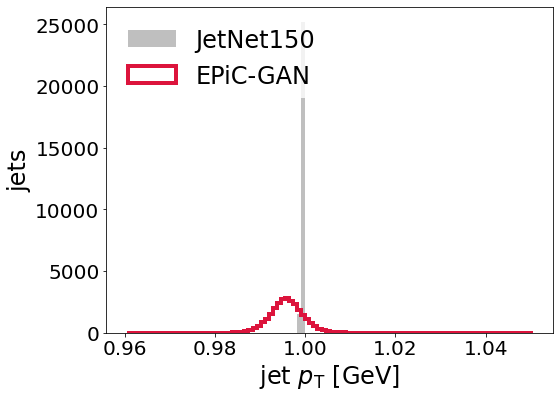

In [372]:
plt.clf()
plt.figure(figsize=(8,6), facecolor='none')
x_min, x_max = np.array([data_pts.min(), reco_pts.min()]).min(), np.array([data_pts.max(), reco_pts.max()]).max()
#x_min, x_max = 0.5, 1.2
hist1 = plt.hist(data_pts, bins=100, label=dataset_name, histtype='stepfilled', range=[x_min,x_max], alpha=0.5, color=color_list[0])#, range=[-10,100])
hist2 = plt.hist(reco_pts, bins=100, label=generator_name, histtype='step', range=[x_min,x_max], lw=4, color=color_list[1])
if plot_mpgan:
    hist2 = plt.hist(gen_mpgan_pts, bins=100, label='MP-GAN', histtype='step', range=[x_min,x_max], lw=4, color=color_list[2], linestyle='--')
plt.legend(loc='upper left', fontsize=24, edgecolor='none')
plt.xlabel(r'jet $p_\mathrm{T}$ [GeV]', fontsize=24)
plt.ylabel('jets', fontsize=24)
#plt.ylim(1,50000)
#plt.yscale('log')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [373]:
importlib.reload(myF)
from scipy.stats import wasserstein_distance as w_dist
print('mass MSE:')
print(((data_ms - reco_ms)**2).mean())
print('JSD mass hist: {:.4f}'.format(myF.JSD_fromHist(hist1,hist2)))
print('Wasserstein-1 distance of jet mass: {:.5f}'.format(w_dist(data_ms, reco_ms)))
print('Wasserstein-1 distance of jet pt: {:.5f}'.format(w_dist(data_pts, reco_pts)))
if plot_mpgan:
    print('for MPGAN set')
    print('Wasserstein-1 distance of jet mass: {:.5f}'.format(w_dist(data_ms, gen_mpgan_ms)))
    print('Wasserstein-1 distance of jet pt: {:.5f}'.format(w_dist(data_pts, gen_mpgan_pts)))

mass MSE:
0.002527719487362454
JSD mass hist: 0.7367
Wasserstein-1 distance of jet mass: 0.00057
Wasserstein-1 distance of jet pt: 0.00427


# My JetNet Metrics

In [374]:
data_test_swp = data_test_ary[:,:,[1,2,0]]
reco_test_swp = reco_test_ary[:,:,[1,2,0]]
gen_mpgan_swp = gen_mpgan[:,:,[1,2,0]]
reco_ary_swp = reco_ary[:,:,[1,2,0]]  # 300k events

In [375]:
# w1m_mean, w1m_std = eval.w1m(data_test_swp, reco_ary_swp, num_eval_samples=len(data_test_ary), num_batches=10)
# print('{:.1f}, {:.1f}'.format(w1m_mean*1e3, w1m_std*1e3))

In [376]:
# w1p_mean, w1p_std = eval.w1p(data_test_swp, reco_ary_swp, num_eval_samples=len(data_test_ary), num_batches=10)
# print('{:.1f}, {:.1f}'.format(w1p_mean*1e3, w1p_std*1e3))

In [377]:
# w1efp_mean, w1efp_std = eval.w1efp(data_test_swp, reco_ary_swp, num_eval_samples=len(data_test_ary), num_batches=10)
# print('{:.1f}, {:.1f}'.format(w1efp_mean*1e5, w1efp_std*1e5))

In [378]:
# if n_points_cut == 30:
#     fpnd_mean, fpnd_std = eval.FPND(reco_ary_swp, lenght=len(data_test_ary), jet_type = jet_type, batches=10)  
#     print('{:.2f}, {:.2f}'.format(fpnd_mean, fpnd_std))

In [379]:
# cov_mean, cov_std, mmd_mean, mmd_std = eval.cov_mmd(data_test_swp, reco_ary_swp, num_batches=10, num_eval_samples=100)
# print('{:.2f}, {:.2f}'.format(cov_mean, cov_std))
# print('{:.3f}, {:.3f}'.format(mmd_mean, mmd_std))

# # note in paper: The Cov and MMD are dependent on the number of evaluation samples, therefore we must leave it at 100, otherwise we cannot get comparable resutls

# Jet Observables

<Figure size 432x288 with 0 Axes>

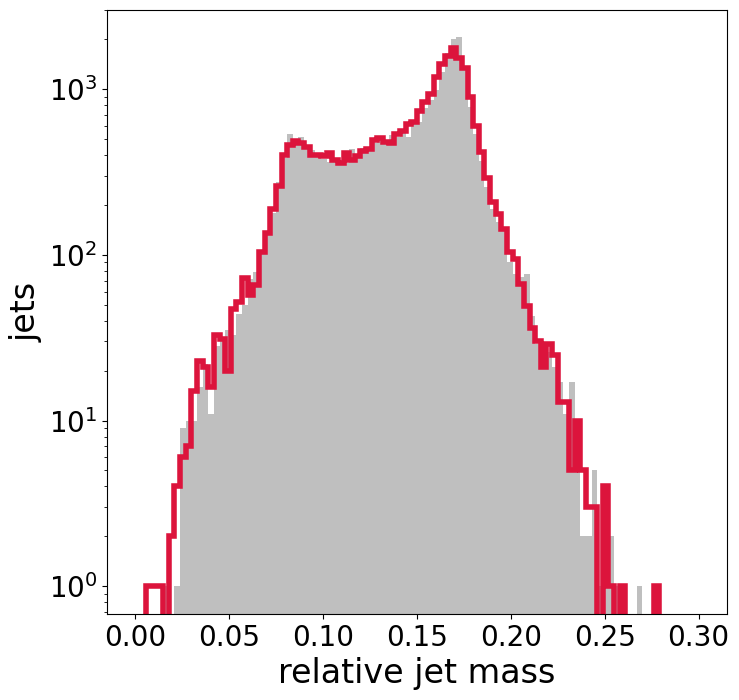

<Figure size 432x288 with 0 Axes>

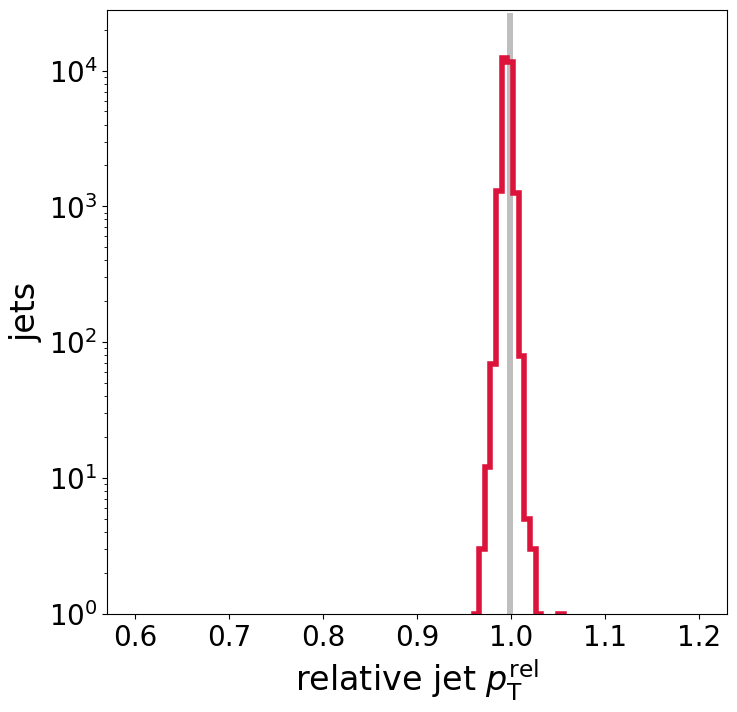

<Figure size 432x288 with 0 Axes>

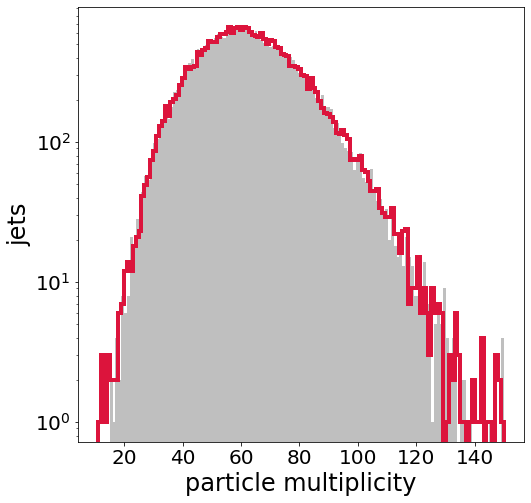

<Figure size 432x288 with 0 Axes>

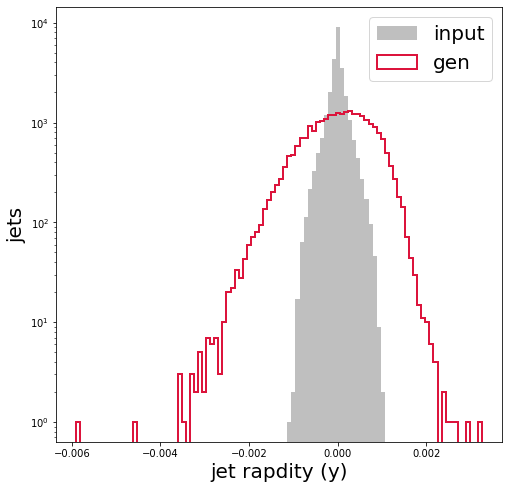

<Figure size 432x288 with 0 Axes>

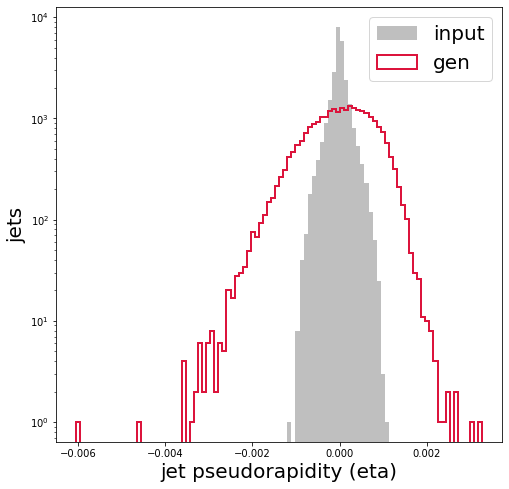

<Figure size 432x288 with 0 Axes>

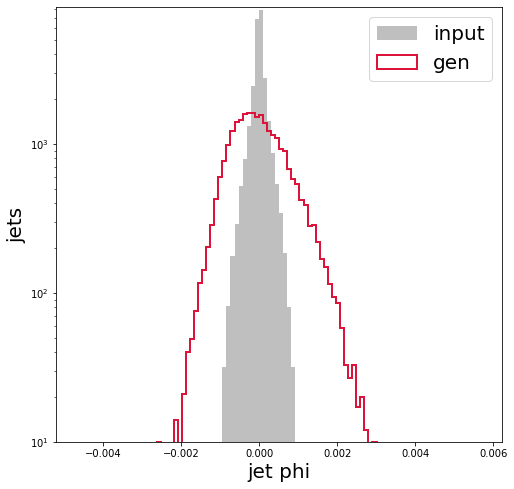

In [380]:
# plot jet level histograms
plt.clf()
plt.figure(figsize=(8,8), facecolor='none', dpi=100)
x_min, x_max = np.array([data_ms.min(), reco_ms.min()]).min(), np.array([data_ms.max(), reco_ms.max()]).max()
x_min, x_max = 0, 0.3
hist1 = plt.hist(data_ms, bins=100, label=dataset_name, histtype='stepfilled', range=[x_min,x_max], alpha=0.5, color=color_list[0])
hist2 = plt.hist(reco_ms, bins=100, label=generator_name, histtype='step', range=[x_min,x_max], lw=4, color=color_list[1])
if plot_mpgan:
    hist2 = plt.hist(gen_mpgan_ms, bins=100, label='MP-GAN', histtype='step', range=[x_min,x_max], lw=4, color=color_list[2], linestyle='--')
# plt.legend(loc='upper right', fontsize=24, edgecolor='none')
plt.xlabel('relative jet mass', fontsize=24)
plt.ylabel('jets', fontsize=24)
plt.yscale('log')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

plt.clf()
plt.figure(figsize=(8,8), facecolor='none',dpi=100)
x_min, x_max = np.array([data_pts.min(), reco_pts.min()]).min(), np.array([data_pts.max(), reco_pts.max()]).max()
x_min, x_max = 0.6, 1.2
hist1 = plt.hist(data_pts, bins=100, label=dataset_name, histtype='stepfilled', range=[x_min,x_max], alpha=0.5, color=color_list[0])#, range=[-10,100])
hist2 = plt.hist(reco_pts, bins=100, label=generator_name, histtype='step', range=[x_min,x_max], lw=4, color=color_list[1])
if plot_mpgan:
    hist2 = plt.hist(gen_mpgan_pts, bins=100, label='MP-GAN', histtype='step', range=[x_min,x_max], lw=4, color=color_list[2], linestyle='--')
#plt.legend(loc='upper left', fontsize=24, edgecolor='none')
plt.xlabel(r'relative jet $p_\mathrm{T}^\mathrm{rel}$', fontsize=24)
plt.ylabel('jets', fontsize=24)
plt.ylim(1,)
plt.yscale('log')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

plt.clf()
plt.figure(figsize=(8,8), facecolor='none')
x_min, x_max = np.array([data_mults.min(), reco_mults.min()]).min(), np.array([data_mults.max(), reco_mults.max()]).max()
b=x_max-x_min+1
hist1 = plt.hist(data_mults, bins=b, label=dataset_name, histtype='stepfilled', alpha=0.5, range=[x_min,x_max], color=color_list[0])
hist2 = plt.hist(reco_mults, bins=b, label=generator_name, histtype='step', lw=4, range=[x_min,x_max], color=color_list[1])
if plot_mpgan:
    hist2 = plt.hist(gen_mpgan_mults, bins=b, label='MP-GAN', histtype='step', range=[x_min,x_max], lw=4, color=color_list[2], linestyle='--')
#plt.legend(loc='upper right', fontsize=24, edgecolor='none')
plt.xlabel('particle multiplicity', fontsize=24)
plt.yscale('log')
plt.ylabel('jets', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

plt.clf()
plt.figure(figsize=(8,8), facecolor='none')
x_min, x_max = np.array([data_ys.min(), reco_ys.min()]).min(), np.array([data_ys.max(), reco_ys.max()]).max()
# x_min, x_max = -.02,.02
hist1 = plt.hist(data_ys, bins=100, label='input', histtype='stepfilled', range=[x_min,x_max], alpha=0.5, color=color_list[0])
hist2 = plt.hist(reco_ys, bins=100, label='gen', histtype='step', range=[x_min,x_max], lw=2, color=color_list[1])
if plot_mpgan:
    hist2 = plt.hist(gen_mpgan_ys, bins=100, label='MP-GAN', histtype='step', range=[x_min,x_max], lw=2, color=color_list[2], linestyle='--')
plt.legend(loc='upper right', fontsize=20)
plt.xlabel('jet rapdity (y)', fontsize=20)
plt.ylabel('jets', fontsize=20)
plt.yscale('log')
plt.show()

plt.clf()
plt.figure(figsize=(8,8), facecolor='none')
x_min, x_max = np.array([data_etas.min(), reco_etas.min()]).min(), np.array([data_etas.max(), reco_etas.max()]).max()
# x_min, x_max = -.02,.02
hist1 = plt.hist(data_etas, bins=100, label='input', histtype='stepfilled', range=[x_min,x_max], alpha=0.5, color=color_list[0])
hist2 = plt.hist(reco_etas, bins=100, label='gen', histtype='step', range=[x_min,x_max], lw=2, color=color_list[1])
if plot_mpgan:
    hist2 = plt.hist(gen_mpgan_etas, bins=100, label='MP-GAN', histtype='step', range=[x_min,x_max], lw=2, color=color_list[2], linestyle='--')
plt.legend(loc='upper right', fontsize=20)
plt.xlabel('jet pseudorapidity (eta)', fontsize=20)
plt.ylabel('jets', fontsize=20)
plt.yscale('log')
plt.show()

plt.clf()
plt.figure(figsize=(8,8), facecolor='none')
x_min, x_max = np.array([data_phis.min(), reco_phis.min()]).min(), np.array([data_phis.max(), reco_phis.max()]).max()
# x_min, x_max = -0.02,.02
hist1 = plt.hist(data_phis, bins=100, label='input', histtype='stepfilled', range=[x_min,x_max], alpha=0.5, color=color_list[0])#, range=[-1,7])
hist2 = plt.hist(reco_phis, bins=100, label='gen', histtype='step', range=[x_min,x_max], lw=2, color=color_list[1])
if plot_mpgan:
    hist2 = plt.hist(gen_mpgan_phis, bins=100, label='MP-GAN', histtype='step', range=[x_min,x_max], lw=2, color=color_list[2], linestyle='--')
plt.legend(loc='upper right', fontsize=20)
plt.xlabel('jet phi', fontsize=20)
plt.ylabel('jets', fontsize=20)
plt.ylim(10,)
plt.yscale('log')
plt.show()

<Figure size 432x288 with 0 Axes>

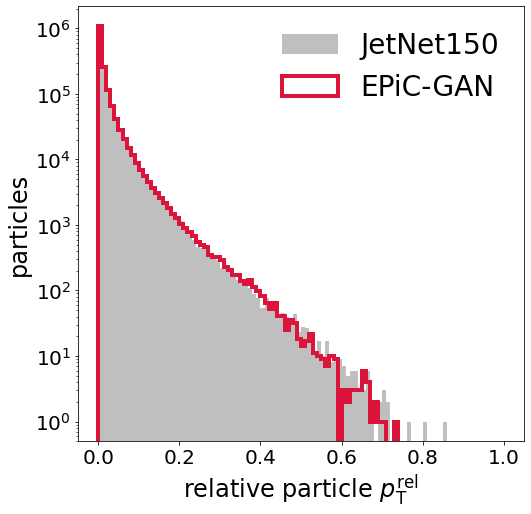

<Figure size 432x288 with 0 Axes>

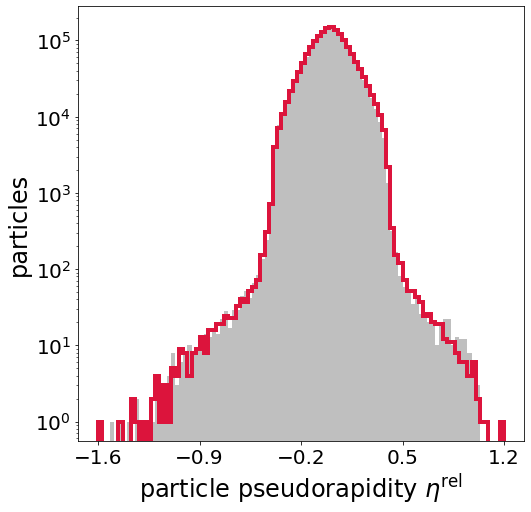

<Figure size 432x288 with 0 Axes>

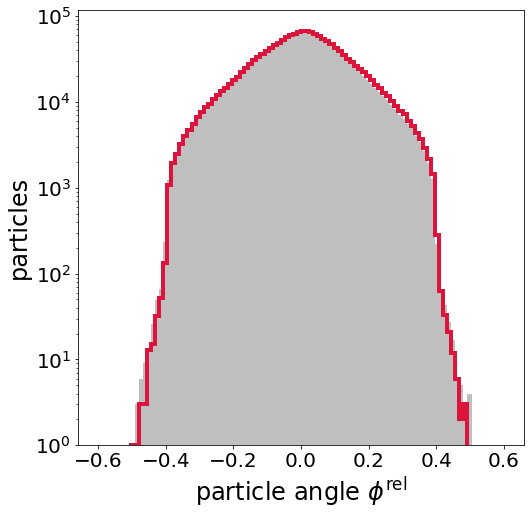

In [381]:
# plot particle level histograms

plt.clf()
plt.figure(figsize=(8,8), facecolor='none')
x_min, x_max = np.array([data_test_ary[:,:,0].flatten().min(), reco_test_ary[:,:,0].flatten().min()]).min(), np.array([data_test_ary[:,:,0].flatten().max(), reco_test_ary[:,:,0].flatten().max()]).max()
x_min, x_max = 0, 1.
hist1 = plt.hist(data_test_ary[:,:,0][data_test_ary[:,:,0] != 0].flatten(), bins=100, label=dataset_name, histtype='stepfilled', range=[x_min,x_max], alpha=0.5, color=color_list[0])#, range=[-100,600])
hist2 = plt.hist(reco_test_ary[:,:,0][reco_test_ary[:,:,0] != 0].flatten(), bins=100, label=generator_name, histtype='step', range=[x_min,x_max], lw=4, color=color_list[1])#, range=[-100,600])
if plot_mpgan:
    hist2 = plt.hist(gen_mpgan[:,:,0][gen_mpgan[:,:,0] != 0].flatten(), bins=100, label='MP-GAN', histtype='step', range=[x_min,x_max], lw=4, color=color_list[2], linestyle='--')#, range=[-100,600])
plt.legend(loc='upper right', fontsize=28,edgecolor='none')
plt.xlabel(r'relative particle $p_\mathrm{T}^\mathrm{rel}$', fontsize=24)
plt.ylabel('particles', fontsize=24)
plt.yscale('log')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.xscale('log')
plt.show()

plt.clf()
plt.figure(figsize=(8,8), facecolor='none')
x_min, x_max = np.array([data_test_ary[:,:,1].flatten().min(), reco_test_ary[:,:,1].flatten().min()]).min(), np.array([data_test_ary[:,:,1].flatten().max(), reco_test_ary[:,:,1].flatten().max()]).max()
x_min, x_max = -1.6,1.2
hist1 = plt.hist(data_test_ary[:,:,1][data_test_ary[:,:,1] != 0].flatten(), bins=100, label=dataset_name, histtype='stepfilled', range=[x_min,x_max], alpha=0.5, color=color_list[0])
hist2 = plt.hist(reco_test_ary[:,:,1][reco_test_ary[:,:,1] != 0].flatten(), bins=hist1[1], label=generator_name, histtype='step', range=[x_min,x_max], lw=4, color=color_list[1])
if plot_mpgan:
    hist2 = plt.hist(gen_mpgan[:,:,1][gen_mpgan[:,:,1] != 0].flatten(), bins=100, label='MP-GAN', histtype='step', range=[x_min,x_max], lw=4, color=color_list[2], linestyle='--')#, range=[-100,600])
#plt.legend(loc='upper right', fontsize=24,edgecolor='none')
plt.xlabel(r'particle pseudorapidity $\eta^\mathrm{rel}$', fontsize=24)
plt.ylabel('particles', fontsize=24)
plt.yscale('log')
plt.xticks(np.linspace(x_min, x_max, 5), fontsize=20)
plt.yticks(fontsize=20)
plt.show()

plt.clf()
plt.figure(figsize=(8,8), facecolor='none')
x_min, x_max = np.array([data_test_ary[:,:,2].flatten().min(), reco_test_ary[:,:,2].flatten().min()]).min(), np.array([data_test_ary[:,:,2].flatten().max(), reco_test_ary[:,:,2].flatten().max()]).max()
x_min, x_max = -.6,.6
hist1 = plt.hist(data_test_ary[:,:,2][data_test_ary[:,:,2] != 0].flatten(), bins=100, label=dataset_name, histtype='stepfilled', range=[x_min,x_max], alpha=0.5, color=color_list[0])
hist2 = plt.hist(reco_test_ary[:,:,2][reco_test_ary[:,:,2] != 0].flatten(), bins=hist1[1], label=generator_name, histtype='step', range=[x_min,x_max], lw=4, color=color_list[1])
if plot_mpgan:
    hist2 = plt.hist(gen_mpgan[:,:,1][gen_mpgan[:,:,0] != 1].flatten(), bins=100, label='MP-GAN', histtype='step', range=[x_min,x_max], lw=4, color=color_list[2], linestyle='--')#, range=[-100,600])
#plt.legend(loc='lower center', fontsize=24, edgecolor='none')
plt.xlabel(r'particle angle $\phi^\mathrm{rel}$', fontsize=24)
plt.ylabel('particles', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.yscale('log')
plt.ylim(1,)
plt.show()

<Figure size 432x288 with 0 Axes>

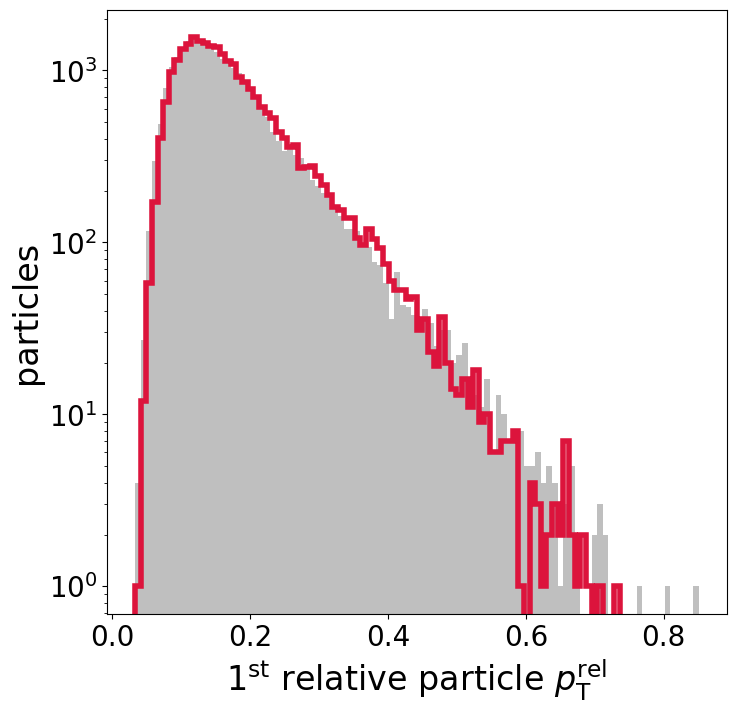

<Figure size 432x288 with 0 Axes>

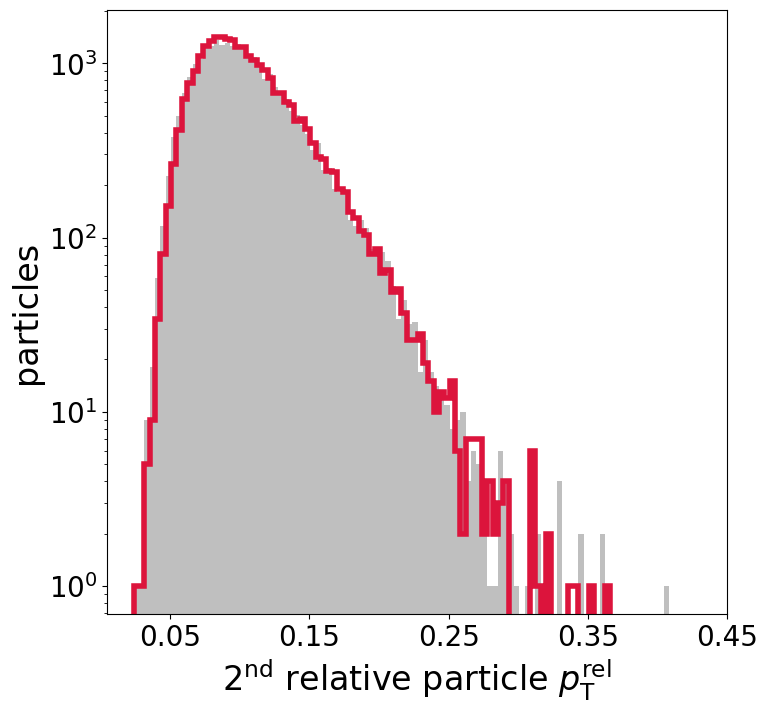

<Figure size 432x288 with 0 Axes>

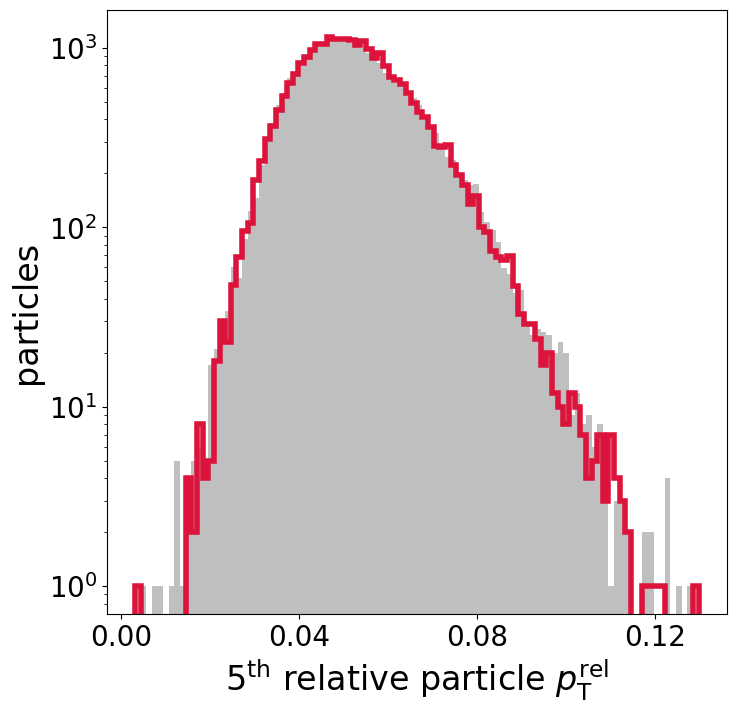

<Figure size 432x288 with 0 Axes>

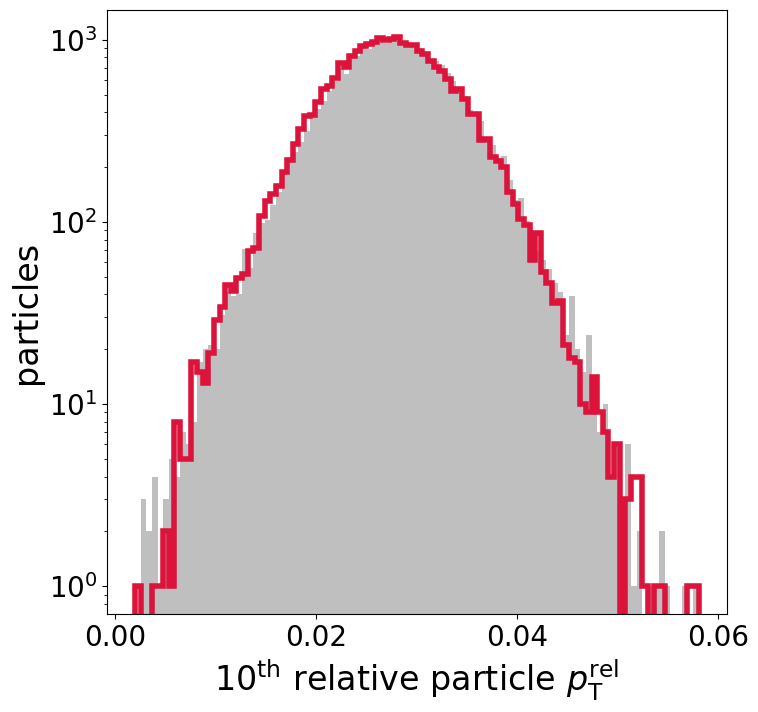

<Figure size 432x288 with 0 Axes>

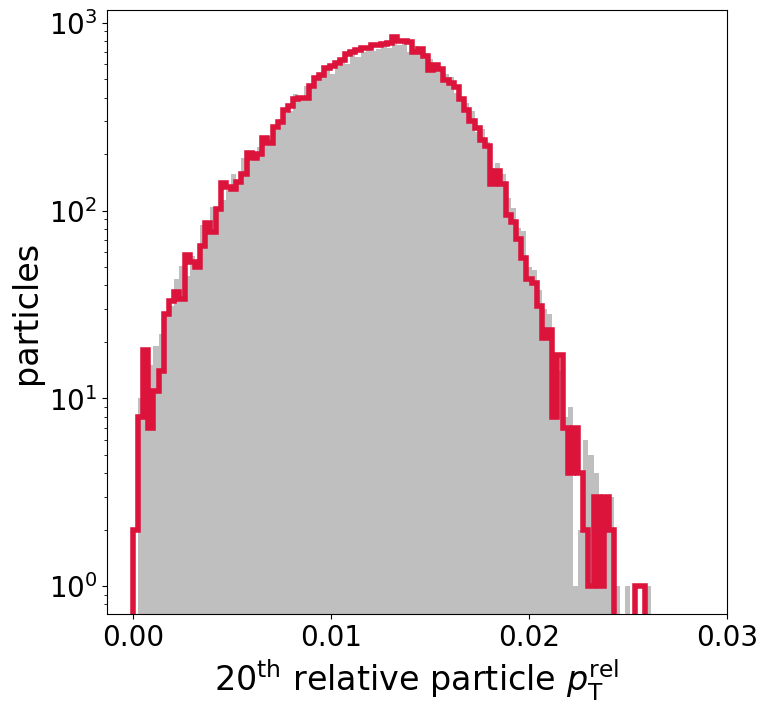

<Figure size 432x288 with 0 Axes>

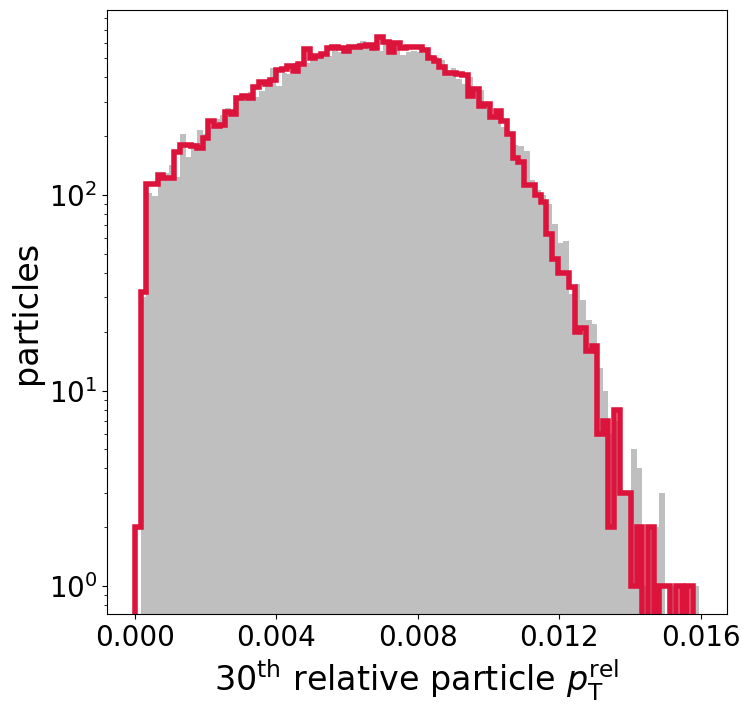

<Figure size 432x288 with 0 Axes>

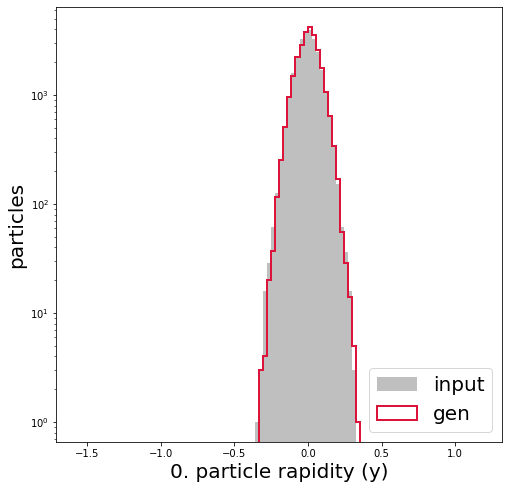

<Figure size 432x288 with 0 Axes>

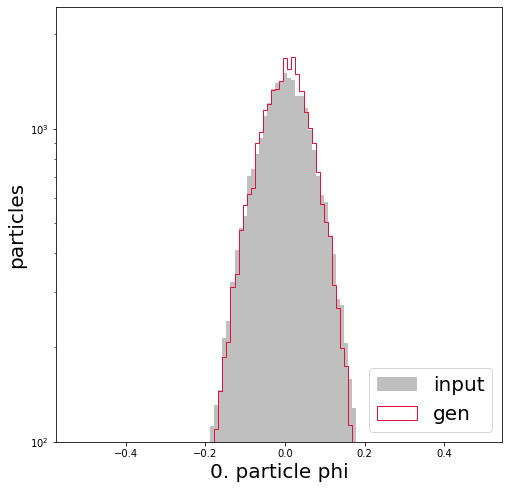

In [382]:
# plot particle level histograms
density = 0
n_points = [0,1,4,9,19,29]
n_points_y = 1

for i in n_points:
    plt.clf()
    plt.figure(figsize=(8,8), facecolor='none', dpi=100)
    x_min, x_max = np.array([data_test_ary[:,i,0].flatten().min(), reco_test_ary[:,i,0].flatten().min()]).min(), np.array([data_test_ary[:,i,0].flatten().max(), reco_test_ary[:,i,0].flatten().max()]).max()
    #x_min, x_max = -.1,.9
    hist1 = plt.hist(data_test_ary[:,i,0][data_test_ary_p4s[:,i,0] != 0].flatten(), bins=100, label=dataset_name, histtype='stepfilled', alpha=0.5, density=density, range=[x_min,x_max], color=color_list[0])
    hist2 = plt.hist(reco_test_ary[:,i,0][reco_test_ary_p4s[:,i,0] != 0].flatten(), bins=100, label=generator_name, histtype='step', density=density, range=[x_min,x_max], lw=4, color=color_list[1])#, range=[-100,600])
    if plot_mpgan:
        hist2 = plt.hist(gen_mpgan[:,i,0][gen_mpgan_p4s[:,i,0] != 0].flatten(), bins=100, label='MP-GAN', histtype='step', density=density, range=[x_min,x_max], lw=4, color=color_list[2], linestyle='--')#, range=[-100,600])
    # if i == 0:
    # plt.legend(loc='lower center', fontsize=24, edgecolor='none')
    if i == 0:
        plt.xlabel('{}'.format(i+1)+r'$^\mathrm{st}$ relative particle $p_\mathrm{T}^\mathrm{rel}$', fontsize=24)
    elif i == 1:
        plt.xlabel('{}'.format(i+1)+r'$^\mathrm{nd}$ relative particle $p_\mathrm{T}^\mathrm{rel}$', fontsize=24)
    elif i == 2:
        plt.xlabel('{}'.format(i+1)+r'$^\mathrm{rd}$ relative particle $p_\mathrm{T}^\mathrm{rel}$', fontsize=24)
    else:
        plt.xlabel('{}'.format(i+1)+r'$^\mathrm{th}$ relative particle $p_\mathrm{T}^\mathrm{rel}$', fontsize=24)
    plt.ylabel('particles', fontsize=24)
    plt.yscale('log')
    plt.gca().set_xticks(plt.gca().get_xticks()[1:][::2])   # hide every second x_tick, starting from the second
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    #plt.xscale('log')
    plt.show()
    
    
for i in range(n_points_y):
    plt.clf()
    plt.figure(figsize=(8,8), facecolor='none')
    x_min, x_max = np.array([data_test_ary[:,:,1].flatten().min(), reco_test_ary[:,:,1].flatten().min()]).min(), np.array([data_test_ary[:,:,1].flatten().max(), reco_test_ary[:,:,1].flatten().max()]).max()
    hist1 = plt.hist(data_test_ary[:,i,1][data_test_ary_p4s[:,i,1] != 0].flatten(), bins=100, label='input', histtype='stepfilled', alpha=0.5, density=density, range=[x_min,x_max], color=color_list[0])
    hist2 = plt.hist(reco_test_ary[:,i,1][reco_test_ary_p4s[:,i,1] != 0].flatten(), bins=100, label='gen', histtype='step', density=density, range=[x_min,x_max], lw=2, color=color_list[1])
    plt.legend(loc='lower right', fontsize=20)
    plt.xlabel('{}. particle rapidity (y)'.format(i), fontsize=20)
    plt.ylabel('particles', fontsize=20)
    plt.yscale('log')
    #plt.xscale('log')
    plt.show()
    
for i in range(n_points_y):
    plt.clf()
    plt.figure(figsize=(8,8), facecolor='none')
    x_min, x_max = np.array([data_test_ary[:,:,2].flatten().min(), reco_test_ary[:,:,2].flatten().min()]).min(), np.array([data_test_ary[:,:,2].flatten().max(), reco_test_ary[:,:,2].flatten().max()]).max()
    hist1 = plt.hist(data_test_ary[:,i,2][data_test_ary_p4s[:,i,2] != 0].flatten(), bins=100, label='input', histtype='stepfilled', alpha=0.5, density=density, range=[x_min,x_max], color=color_list[0])
    hist2 = plt.hist(reco_test_ary[:,i,2][reco_test_ary_p4s[:,i,2] != 0].flatten(), bins=100, label='gen', histtype='step', density=density, range=[x_min,x_max], color=color_list[1])#, range=[-100,600])
    plt.legend(loc='lower right', fontsize=20)
    plt.xlabel('{}. particle phi'.format(i), fontsize=20)
    plt.ylabel('particles', fontsize=20)
    plt.yscale('log')
    plt.ylim(1e2,)
    #plt.xscale('log')
    plt.show()

<Figure size 432x288 with 0 Axes>

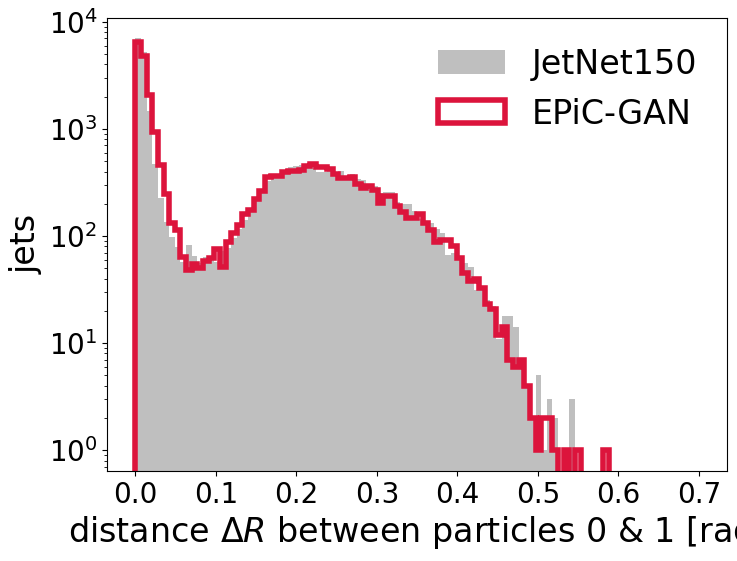

In [383]:
#delta R

x = np.sqrt((data_test_ary[:,0,1] - data_test_ary[:,1,1])**2 + (data_test_ary[:,0,2] - data_test_ary[:,1,2])**2)
y = np.sqrt((reco_test_ary[:,0,1] - reco_test_ary[:,1,1])**2 + (reco_test_ary[:,0,2] - reco_test_ary[:,1,2])**2)
distance_R = y
plt.clf()
plt.figure(figsize=(8,6), facecolor='none', dpi=100)
#x_min, x_max = np.array([data_test_ary_p3s[:,:,2].flatten().min(), reco_test_ary_p3s[:,:,2].flatten().min()]).min(), np.array([data_test_ary_p3s[:,:,2].flatten().max(), reco_test_ary_p3s[:,:,2].flatten().max()]).max()
x_min, x_max = 0,0.7
hist1 = plt.hist(x, bins=100, label=dataset_name, histtype='stepfilled', range=[x_min,x_max], alpha=0.5, color=color_list[0])
hist2 = plt.hist(y, bins=hist1[1], label=generator_name, histtype='step', range=[x_min,x_max], lw=4, color=color_list[1])
plt.legend(loc='upper right', fontsize=24, edgecolor='none')
plt.xlabel(r'distance $\Delta R$ between particles 0 & 1 [rad]', fontsize=24)
plt.ylabel('jets', fontsize=24)
plt.yscale('log')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

plot saved


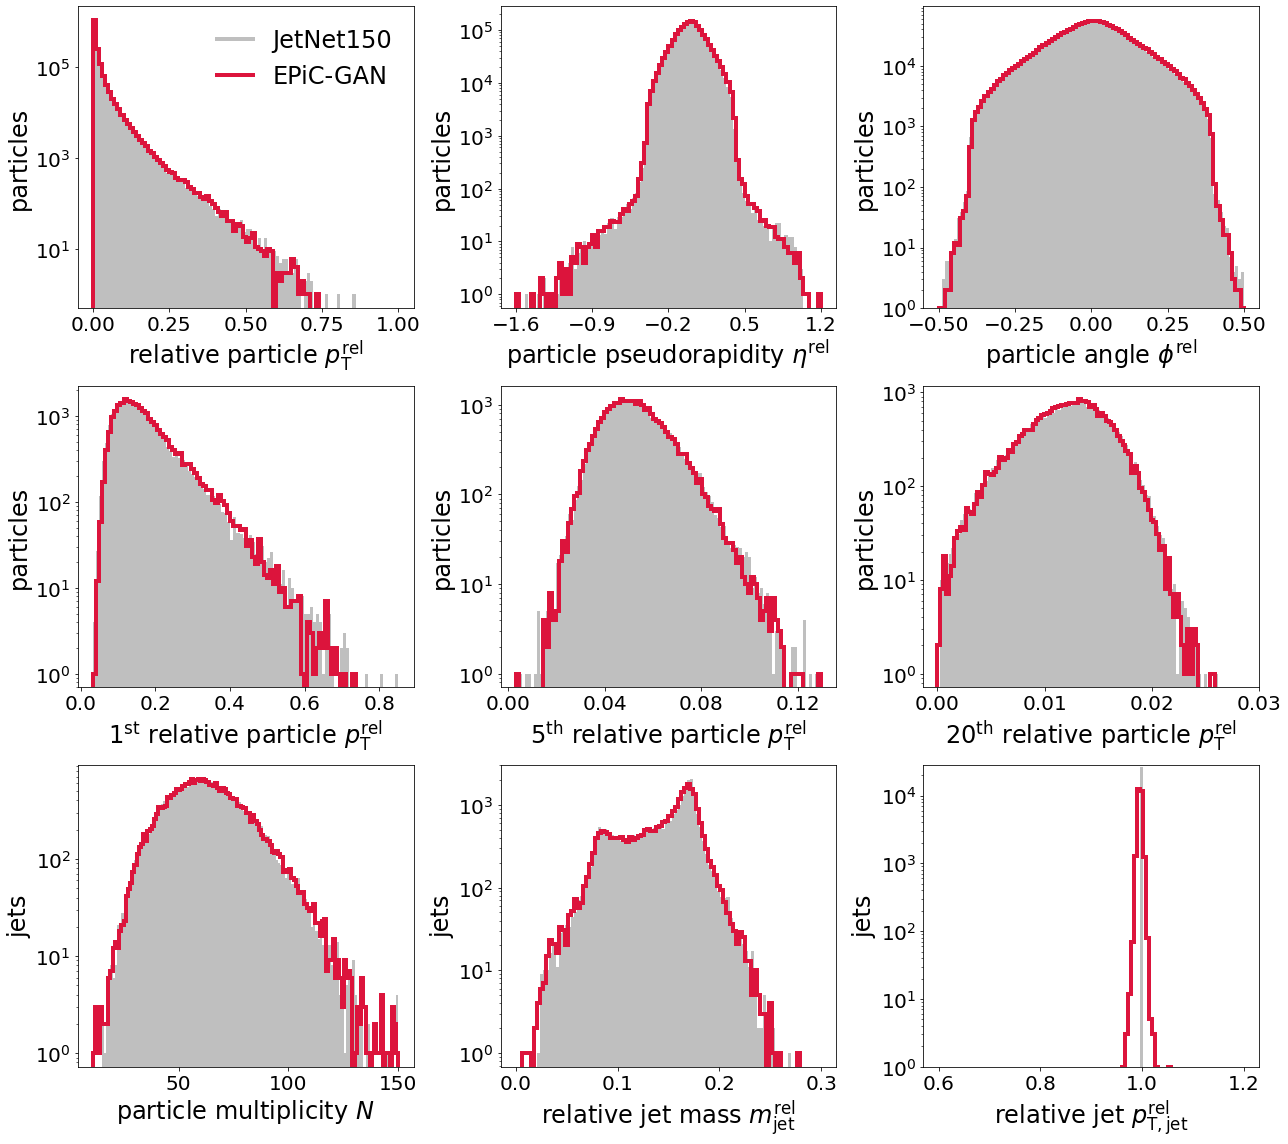

In [384]:
# overview plots
density = 0
plot_generation = True
fig = plt.figure(figsize=(18, 16), facecolor='none')
gs = GridSpec(3,3)
alphas = [0.5, 1, 1]
linestyles = ['-', '-', '--']

# particle pt 
ax = fig.add_subplot(gs[0])
x_min, x_max = np.array([data_test_ary[:,:,0].flatten().min(), reco_test_ary[:,:,0].flatten().min()]).min(), np.array([data_test_ary[:,:,0].flatten().max(), reco_test_ary[:,:,0].flatten().max()]).max()
x_min, x_max = 0, 1.
hist1 = ax.hist(data_test_ary[:,:,0][data_test_ary[:,:,0] != 0].flatten(), bins=100, label=dataset_name, histtype='stepfilled', range=[x_min,x_max], alpha=0.5, color=color_list[0])#, range=[-100,600])
if plot_generation:
    hist2 = ax.hist(reco_test_ary[:,:,0][reco_test_ary[:,:,0] != 0].flatten(), bins=100, label=generator_name, histtype='step', range=[x_min,x_max], lw=4, color=color_list[1])#, range=[-100,600])
if plot_mpgan:
    hist2 = ax.hist(gen_mpgan[:,:,0][gen_mpgan[:,:,0] != 0].flatten(), bins=100, label='MP-GAN', histtype='step', range=[x_min,x_max], lw=4, color=color_list[2], linestyle='--')#, range=[-100,600])
# Create new legend handles but use the colors from the existing ones
handles, labels = ax.get_legend_handles_labels()
new_handles = [plt.Line2D([], [], c=color_list[i], alpha=alphas[i], lw=4, linestyle=linestyles[i]) for i in range(len(handles))]
ax.legend(handles=new_handles, labels=labels, loc='upper right', fontsize=24,edgecolor='none', facecolor='none', handlelength=1.5)
ax.set_xlabel(r'relative particle $p_\mathrm{T}^\mathrm{rel}$', fontsize=24)
ax.set_ylabel('particles', fontsize=24)
ax.set_yscale('log')
ax.tick_params(labelsize=20)
#plt.xscale('log')

# particle rap
ax = fig.add_subplot(gs[1])
x_min, x_max = np.array([data_test_ary[:,:,1].flatten().min(), reco_test_ary[:,:,1].flatten().min()]).min(), np.array([data_test_ary[:,:,1].flatten().max(), reco_test_ary[:,:,1].flatten().max()]).max()
x_min, x_max = -1.6,1.2
hist1 = ax.hist(data_test_ary[:,:,1][data_test_ary[:,:,1] != 0].flatten(), bins=100, label=dataset_name, histtype='stepfilled', range=[x_min,x_max], alpha=0.5, color=color_list[0])
if plot_generation:
    hist2 = ax.hist(reco_test_ary[:,:,1][reco_test_ary[:,:,1] != 0].flatten(), bins=hist1[1], label=generator_name, histtype='step', range=[x_min,x_max], lw=4, color=color_list[1])
if plot_mpgan:
    hist2 = ax.hist(gen_mpgan[:,:,1][gen_mpgan[:,:,1] != 0].flatten(), bins=100, label='MP-GAN', histtype='step', range=[x_min,x_max], lw=4, color=color_list[2], linestyle='--')#, range=[-100,600])
#plt.legend(loc='upper right', fontsize=24,edgecolor='none')
ax.set_xlabel(r'particle pseudorapidity $\eta^\mathrm{rel}$', fontsize=24)
ax.set_ylabel('particles', fontsize=24)
ax.set_yscale('log')
ax.tick_params(labelsize=20)
ax.set_xticks(np.linspace(x_min, x_max, 5))

# particle phi
ax = fig.add_subplot(gs[2])
x_min, x_max = np.array([data_test_ary[:,:,2].flatten().min(), reco_test_ary[:,:,2].flatten().min()]).min(), np.array([data_test_ary[:,:,2].flatten().max(), reco_test_ary[:,:,2].flatten().max()]).max()
x_min, x_max = -.5,.5
hist1 = ax.hist(data_test_ary[:,:,2][data_test_ary[:,:,2] != 0].flatten(), bins=100, label=dataset_name, histtype='stepfilled', range=[x_min,x_max], alpha=0.5, color=color_list[0])
if plot_generation:
    hist2 = ax.hist(reco_test_ary[:,:,2][reco_test_ary[:,:,2] != 0].flatten(), bins=hist1[1], label=generator_name, histtype='step', range=[x_min,x_max], lw=4, color=color_list[1])
if plot_mpgan:
    hist2 = plt.hist(gen_mpgan[:,:,1][gen_mpgan[:,:,0] != 1].flatten(), bins=100, label='MP-GAN', histtype='step', range=[x_min,x_max], lw=4, color=color_list[2], linestyle='--')#, range=[-100,600])
#plt.legend(loc='lower center', fontsize=24, edgecolor='none')
ax.set_xlabel(r'particle angle $\phi^\mathrm{rel}$', fontsize=24)
ax.set_ylabel('particles', fontsize=24)
ax.set_yscale('log')
ax.set_ylim(1,)
ax.tick_params(labelsize=20)


n_points = [0,4,19]
axes = [3,4,5]
for j in range(3):
    i = n_points[j]
    ax = fig.add_subplot(gs[axes[j]])
    x_min, x_max = np.array([data_test_ary[:,i,0].flatten().min(), reco_test_ary[:,i,0].flatten().min()]).min(), np.array([data_test_ary[:,i,0].flatten().max(), reco_test_ary[:,i,0].flatten().max()]).max()
    #x_min, x_max = -.1,.9
    hist1 = ax.hist(data_test_ary[:,i,0][data_test_ary_p4s[:,i,0] != 0].flatten(), bins=100, label=dataset_name, histtype='stepfilled', alpha=0.5, density=density, range=[x_min,x_max], color=color_list[0])
    if plot_generation:
        hist2 = ax.hist(reco_test_ary[:,i,0][reco_test_ary_p4s[:,i,0] != 0].flatten(), bins=100, label=generator_name, histtype='step', density=density, range=[x_min,x_max], lw=4, color=color_list[1])#, range=[-100,600])
    if plot_mpgan:
        hist2 = ax.hist(gen_mpgan[:,i,0][gen_mpgan_p4s[:,i,0] != 0].flatten(), bins=100, label='MP-GAN', histtype='step', density=density, range=[x_min,x_max], lw=4, color=color_list[2], linestyle='--')#, range=[-100,600])
    # if i == 0:
    # plt.legend(loc='lower center', fontsize=24, edgecolor='none')
    if i == 0:
        ax.set_xlabel('{}'.format(i+1)+r'$^\mathrm{st}$ relative particle $p_\mathrm{T}^\mathrm{rel}$', fontsize=24)
    elif i == 1:
        ax.set_xlabel('{}'.format(i+1)+r'$^\mathrm{nd}$ relative particle $p_\mathrm{T}^\mathrm{rel}$', fontsize=24)
    elif i == 2:
        ax.set_xlabel('{}'.format(i+1)+r'$^\mathrm{rd}$ relative particle $p_\mathrm{T}^\mathrm{rel}$', fontsize=24)
    else:
        ax.set_xlabel('{}'.format(i+1)+r'$^\mathrm{th}$ relative particle $p_\mathrm{T}^\mathrm{rel}$', fontsize=24)
    ax.set_ylabel('particles', fontsize=24)
    ax.set_yscale('log')
    ax.set_xticks(ax.get_xticks()[1:][::2])   # hide every second x_tick, starting from the second
    ax.tick_params(labelsize=20)
    #plt.xscale('log')


# jet mults
ax = fig.add_subplot(gs[6])
x_min, x_max = np.array([data_mults.min(), reco_mults.min()]).min(), np.array([data_mults.max(), reco_mults.max()]).max()
b=x_max-x_min+1
hist1 = ax.hist(data_mults, bins=b, label=dataset_name, histtype='stepfilled', alpha=0.5, range=[x_min,x_max], color=color_list[0])
if plot_generation:
    hist2 = ax.hist(reco_mults, bins=b, label=generator_name, histtype='step', lw=4, range=[x_min,x_max], color=color_list[1])
if plot_mpgan:
    hist2 = ax.hist(gen_mpgan_mults, bins=b, label='MP-GAN', histtype='step', range=[x_min,x_max], lw=4, color=color_list[2], linestyle='--')
#plt.legend(loc='upper right', fontsize=24, edgecolor='none')
ax.set_xlabel(r'particle multiplicity $N$', fontsize=24)
ax.set_yscale('log')
ax.set_ylabel('jets', fontsize=24)
ax.tick_params(labelsize=20)

# jet mass
ax = fig.add_subplot(gs[7])
x_min, x_max = np.array([data_ms.min(), reco_ms.min()]).min(), np.array([data_ms.max(), reco_ms.max()]).max()
x_min, x_max = 0, 0.3
hist1 = ax.hist(data_ms, bins=100, label=dataset_name, histtype='stepfilled', range=[x_min,x_max], alpha=0.5, color=color_list[0])
if plot_generation:
    hist2 = ax.hist(reco_ms, bins=100, label=generator_name, histtype='step', range=[x_min,x_max], lw=4, color=color_list[1])
if plot_mpgan:
    hist2 = ax.hist(gen_mpgan_ms, bins=100, label='MP-GAN', histtype='step', range=[x_min,x_max], lw=4, color=color_list[2], linestyle='--')
# plt.legend(loc='upper right', fontsize=24, edgecolor='none')
ax.set_xlabel(r'relative jet mass $m_\mathrm{jet}^\mathrm{rel}$', fontsize=24)
ax.set_ylabel('jets', fontsize=24)
ax.set_yscale('log')
ax.tick_params(labelsize=20)

#jet pt
ax = fig.add_subplot(gs[8])
x_min, x_max = np.array([data_pts.min(), reco_pts.min()]).min(), np.array([data_pts.max(), reco_pts.max()]).max()
x_min, x_max = 0.6, 1.2
hist1 = ax.hist(data_pts, bins=100, label=dataset_name, histtype='stepfilled', range=[x_min,x_max], alpha=0.5, color=color_list[0])#, range=[-10,100])
if plot_generation:
    hist2 = ax.hist(reco_pts, bins=100, label=generator_name, histtype='step', range=[x_min,x_max], lw=4, color=color_list[1])
if plot_mpgan:
    hist2 = ax.hist(gen_mpgan_pts, bins=100, label='MP-GAN', histtype='step', range=[x_min,x_max], lw=4, color=color_list[2], linestyle='--')
#plt.legend(loc='upper left', fontsize=24, edgecolor='none')
ax.set_xlabel(r'relative jet $p_\mathrm{T, jet}^\mathrm{rel}$', fontsize=24)
ax.set_ylabel('jets', fontsize=24)
ax.set_ylim(1,)
ax.set_yscale('log')
ax.tick_params(labelsize=20)


plt.tight_layout()

if save_plots:
    def create_output_folder(outpath):
        if not os.path.exists(outpath):
            os.makedirs(outpath)
            print("ouput directory created in ", outpath)
    create_output_folder(pdf_folder)
    plt.savefig(pdf_folder+'overview.pdf', bbox_inches='tight', dpi=300)
    print('plot saved')

plt.show()



In [385]:
len(handles)

2

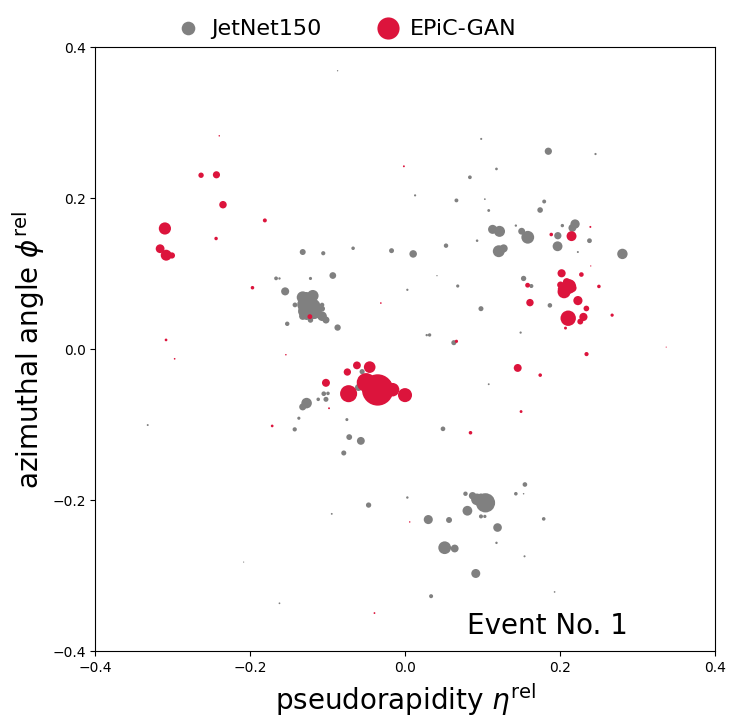

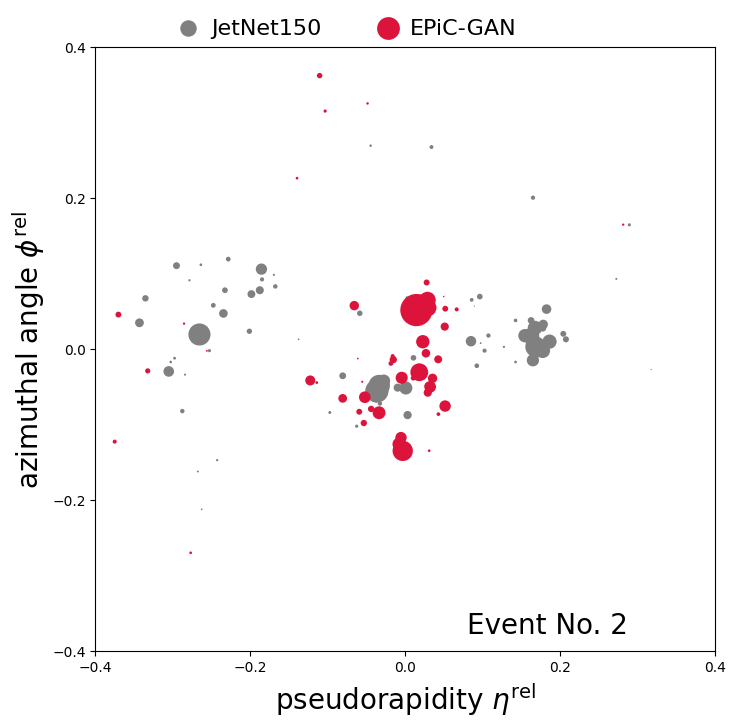

In [386]:
# a few sample events
R = 0.4

for j in range(1,3):
    # choose interesting events
    #i = 4   # 5 and 20 work
    #ev0, ev1 = data_test_ary_centered[j,0:2,:], reco_test_ary_centered[j,0:2,:] 
    ev0, ev1 = data_test_ary[j], reco_test_ary[j] 
    # ev0 = data_test_ary[j]

    # plot the two events
    plt.figure(figsize=(8,8), facecolor='none', dpi=100)
    colors = ['grey', 'crimson']
    labels = [dataset_name, generator_name]
    for i,ev in enumerate([ev0, ev1]):
        pts, ys, phis = ev[:,0], ev[:,1], ev[:,2]
        plt.scatter(ys, phis, marker='o', s=3000*pts, color=colors[i], lw=0, zorder=10, label=labels[i])

    # plot settings
    plt.xlim(-R, R); plt.ylim(-R, R)
    plt.xlabel(r'pseudorapidity $\eta^\mathrm{rel}$', fontsize=20); plt.ylabel(r'azimuthal angle $\phi^\mathrm{rel}$', fontsize=20)
    plt.xticks(np.linspace(-R, R, 5)); plt.yticks(np.linspace(-R, R, 5))

    plt.text(0.6, 0.03, 'Event No. {}'.format(j), fontsize=20, transform=plt.gca().transAxes)
    plt.legend(loc=(0.1, 1.0), frameon=False, ncol=2, handletextpad=0, fontsize=16)

    plt.show()


# Energy Flow Polynomials

In [387]:
# energy flow polynomials
data_test_swp = data_test_ary[:,:,[1,2,0]]
reco_test_swp = reco_test_ary[:,:,[1,2,0]]
gen_mpgan_swp = gen_mpgan[:,:,[1,2,0]]

In [388]:
n = 300000
data_efps = jetnet.utils.efps(data_test_swp[0:n])
reco_efps = jetnet.utils.efps(reco_test_swp[0:n])

In [389]:
data_efps.shape, reco_efps.shape

((26692, 5), (26692, 5))

<Figure size 432x288 with 0 Axes>

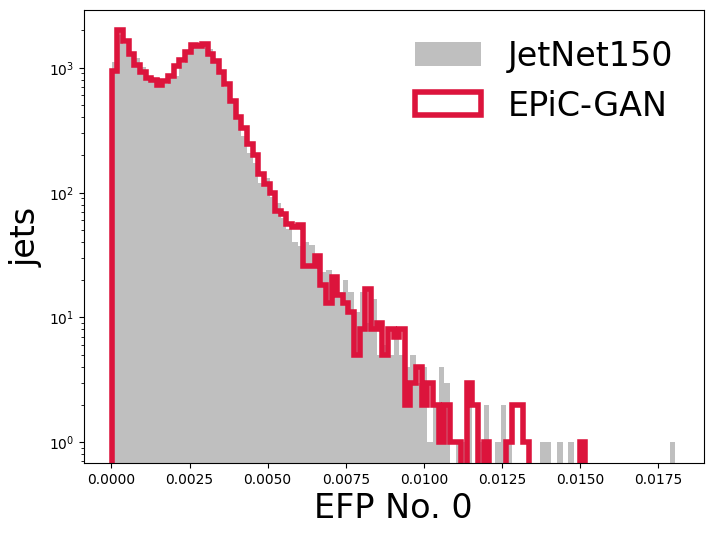

<Figure size 432x288 with 0 Axes>

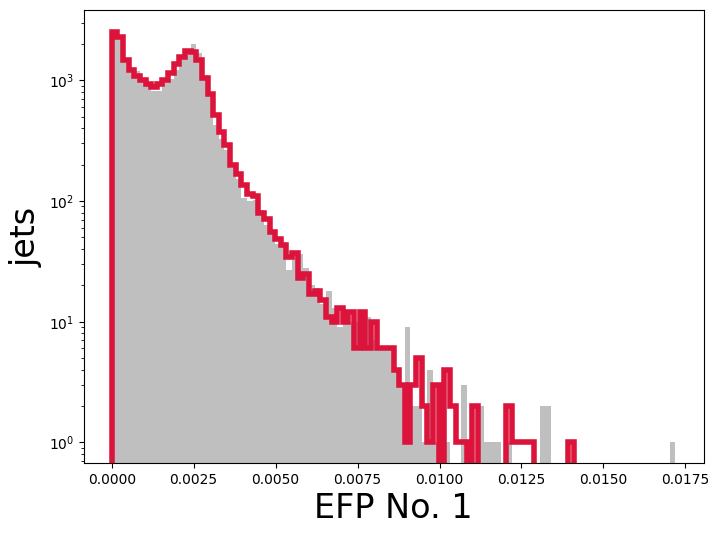

<Figure size 432x288 with 0 Axes>

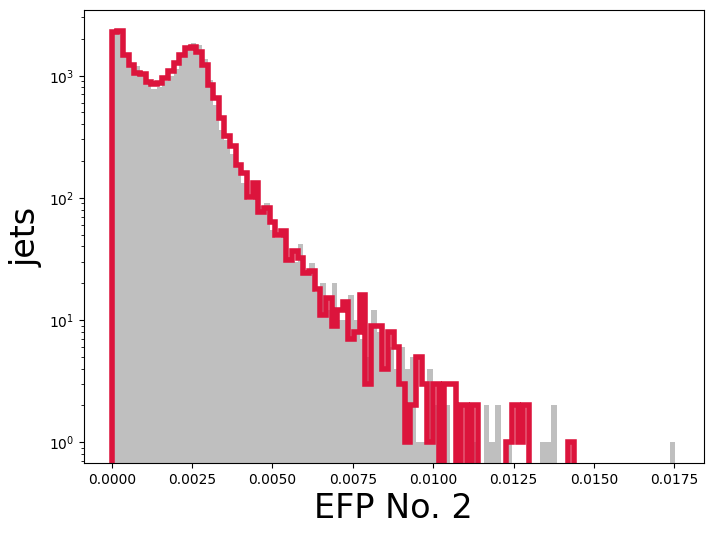

<Figure size 432x288 with 0 Axes>

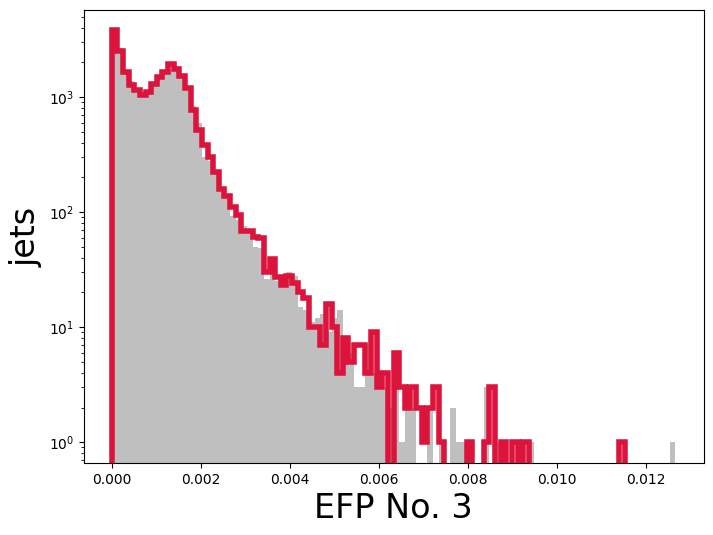

<Figure size 432x288 with 0 Axes>

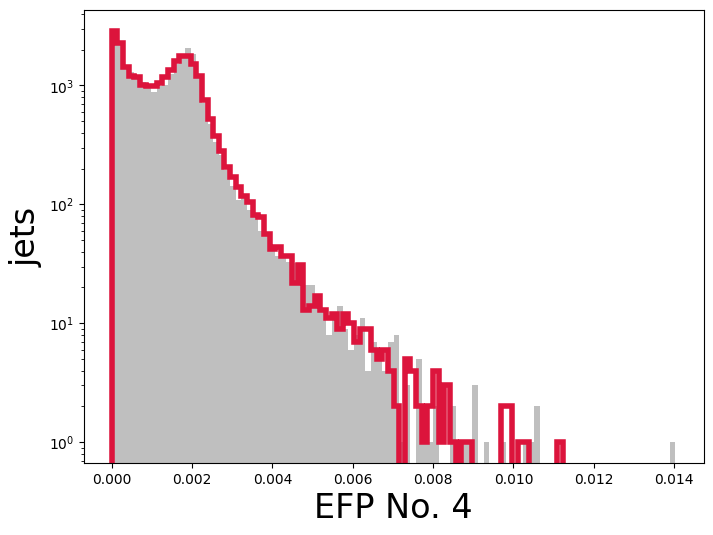

In [390]:
# EFP 0 is the one they plot in the JetNet Paper as "JET EFP"


for i in range(5):

    # plot jet level histograms
    plt.clf()
    plt.figure(figsize=(8,6), facecolor='none', dpi=100)
    hist = plt.hist(data_efps[:,i], bins=100, label=dataset_name, histtype='stepfilled',alpha=0.5, color=color_list[0])#, range=[0,1.5e9])
    plt.hist(reco_efps[:,i], bins=hist[1], label=generator_name, histtype='step', lw=4, color=color_list[1])#, range=[-10,140])
    #hist2 = plt.hist(reco_ms, bins=hist1[1], label='reco', histtype='step')
    if i == 0:
        plt.legend(loc='upper right', fontsize=24, edgecolor='none')
    plt.xlabel('EFP No. {}'.format(i), fontsize=24)
    plt.ylabel('jets', fontsize=24)
    plt.yscale('log')
    plt.show()

# JetNet Metrices

In [391]:
data_test_swp = data_test_ary[:,:,[1,2,0]]
reco_test_swp = reco_test_ary[:,:,[1,2,0]]
gen_mpgan_swp = gen_mpgan[:,:,[1,2,0]]
reco_ary_swp = reco_ary[:,:,[1,2,0]]  # 300k events

In [392]:
w1m_score_mpgan = jetnet.evaluation.w1m(data_test_swp, gen_mpgan_swp, num_eval_samples = 5000)   ## # IN JetNet papaer: 10000!!
w1m_score_reco = jetnet.evaluation.w1m(data_test_swp, reco_test_swp, num_eval_samples = 5000, num_batches=5)

print('w1m')
print(np.array(w1m_score_mpgan)*1e3 )
print(np.array(w1m_score_reco)*1e3 ) 

w1m
[19.44269142  0.71321143]
[0.98713282 0.29531375]


In [393]:

w1p_score_mpgan = jetnet.evaluation.w1p(data_test_swp, gen_mpgan_swp, num_eval_samples = 5000)
w1p_score_reco = jetnet.evaluation.w1p(data_test_swp, reco_test_swp, num_eval_samples = 5000)

print('w1p:')
print(np.array(w1p_score_mpgan)*1e3)
print(np.array(w1p_score_reco)*1e3)

w1p:
[17.9687949   0.51056721]
[2.89147457 0.62389657]


In [394]:
# w1efp_score_mpgan = jetnet.evaluation.w1efp(data_test_swp, gen_mpgan_swp, num_eval_samples = 5000)
# w1efp_score_reco = jetnet.evaluation.w1efp(data_test_swp, reco_test_swp, num_eval_samples = 5000)

# print('w1efp:')
# print(np.array(w1efp_score_mpgan)*1e5)
# print(np.array(w1efp_score_reco)*1e5)

In [395]:
# if n_points_cut == 30:
#     fpnd_score_reco = jetnet.evaluation.fpnd(reco_test_swp, jet_type=jet_type)
#     print('fpnd:')
#     print(fpnd_score_reco)

#     fpnd_score_mpgan = jetnet.evaluation.fpnd(gen_mpgan_swp, jet_type=jet_type)
#     fpnd_score_data = jetnet.evaluation.fpnd(data_test_swp, jet_type=jet_type)

#     print(fpnd_score_mpgan)
#     print(fpnd_score_data)

In [396]:
# cov_mmd_score_mpgan = jetnet.evaluation.cov_mmd(data_test_swp, gen_mpgan_swp)
# cov_mmd_score_reco = jetnet.evaluation.cov_mmd(data_test_swp, reco_test_swp, num_batches=10)

# print('cov and mmd:')
# print(cov_mmd_score_mpgan)
# print(cov_mmd_score_reco)

# My JetNet Metrics

# Truth metrics



In [397]:
# data_train_ary = np.load(f_train)  # (jets, feats, particles)
# # back to physics convention (jets, particles, features)
# data_train_ary = np.moveaxis(data_train_ary, 2,1) 
# print(data_train_ary.shape)

# data_train_swp = data_train_ary[:,:,[1,2,0]]

# print('w1m')
# w1m_mean, w1m_std = eval.w1m(data_test_swp, data_train_swp, num_eval_samples=len(data_test_ary), num_batches=4)
# print('{:.1f}, {:.1f}'.format(w1m_mean*1e3, w1m_std*1e3))

# print('w1p')
# w1p_mean, w1p_std = eval.w1p(data_test_swp, data_train_swp, num_eval_samples=len(data_test_ary), num_batches=4)
# print('{:.1f}, {:.1f}'.format(w1p_mean*1e3, w1p_std*1e3))

# print('w1efp')
# w1efp_mean, w1efp_std = eval.w1efp(data_test_swp, data_train_swp, num_eval_samples=len(data_test_ary), num_batches=4)
# print('{:.1f}, {:.1f}'.format(w1efp_mean*1e5, w1efp_std*1e5))

# if n_points_cut == 30:
#     print('fpnd')
#     fpnd_mean, fpnd_std = eval.FPND(data_train_swp, lenght=len(data_test_ary), jet_type = jet_type, batches=4)  
#     print('{:.2f}, {:.2f}'.format(fpnd_mean, fpnd_std))


# cov_mean, cov_std, mmd_mean, mmd_std = eval.cov_mmd(data_test_swp, data_train_swp, num_batches=10, num_eval_samples=100)
# print('cov')
# print('{:.2f}, {:.2f}'.format(cov_mean, cov_std))
# print('mmd')
# print('{:.3f}, {:.3f}'.format(mmd_mean, mmd_std))

# Distance Correlations with Latent Space

In [398]:
import dcor

# add efps?

observables = np.concatenate([reco_ms.reshape(-1,1),
                              reco_pts.reshape(-1,1),
                              reco_etas.reshape(-1,1),
                              reco_phis.reshape(-1,1),
                              reco_mults.reshape(-1,1),
                              #reco_efps,
                             ], 1)

names_list = [ r'$m_\mathrm{jet}^\mathrm{rel}$', r'$p_\mathrm{T,jet}^\mathrm{rel}$',
               r'$\eta_\mathrm{jet}^\mathrm{rel}$', r'$\phi_\mathrm{jet}^\mathrm{rel}$', r'$N$',
               #r'EFP$_1$', r'EFP$_2$', r'EFP$_3$', r'EFP$_4$', r'EFP$_5$' 
               ]
latent_names = []
for i in range(latent_np.shape[2]):
    latent_names.append(r'$z_{}$'.format(i))

observables.shape, latent_np.shape

((26692, 5), (299982, 8, 10))

In [399]:
%%time
mat = []
n = 5000
for j in range(observables.shape[1]):
    out = []
    for i in range(latent_np.shape[1]):
        disco = dcor.distance_correlation(observables[:n,j], latent_np[:n,i,:])
        out.append(disco)
    mat.append(out)
    print(out)
mat = np.vstack(mat)

[0.0501056749864371, 0.029942811801939972, 0.5060334631800079, 0.5382919156887589, 0.3886729821357324, 0.5578305718702612, 0.18118703543609152, 0.23822392661179906]
[0.04881012720131133, 0.029608938044108277, 0.07927013851517481, 0.1092583564865105, 0.08934865030412181, 0.15741458322200205, 0.1736834507151024, 0.14153796705132302]
[0.0495929633717531, 0.030082140641462723, 0.3207311886889766, 0.3771823920679825, 0.23505656836366112, 0.350784069904587, 0.5034445898621529, 0.5007784946613368]
[0.04453571266539476, 0.02536975352327999, 0.16975215085920153, 0.30357100650907753, 0.12924966451644493, 0.1781227743430621, 0.3516048901341859, 0.23014765423204847]
[0.04551662766802086, 0.022382190124789796, 0.9414057226568215, 0.31949807214397186, 0.3359689900534981, 0.31028925634713656, 0.12038636193270923, 0.17286691874697188]
CPU times: user 15.4 s, sys: 10.4 s, total: 25.8 s
Wall time: 25.9 s


plot saved


<ipython-input-400-fb3e838ea5b9>:43: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_cor.show()


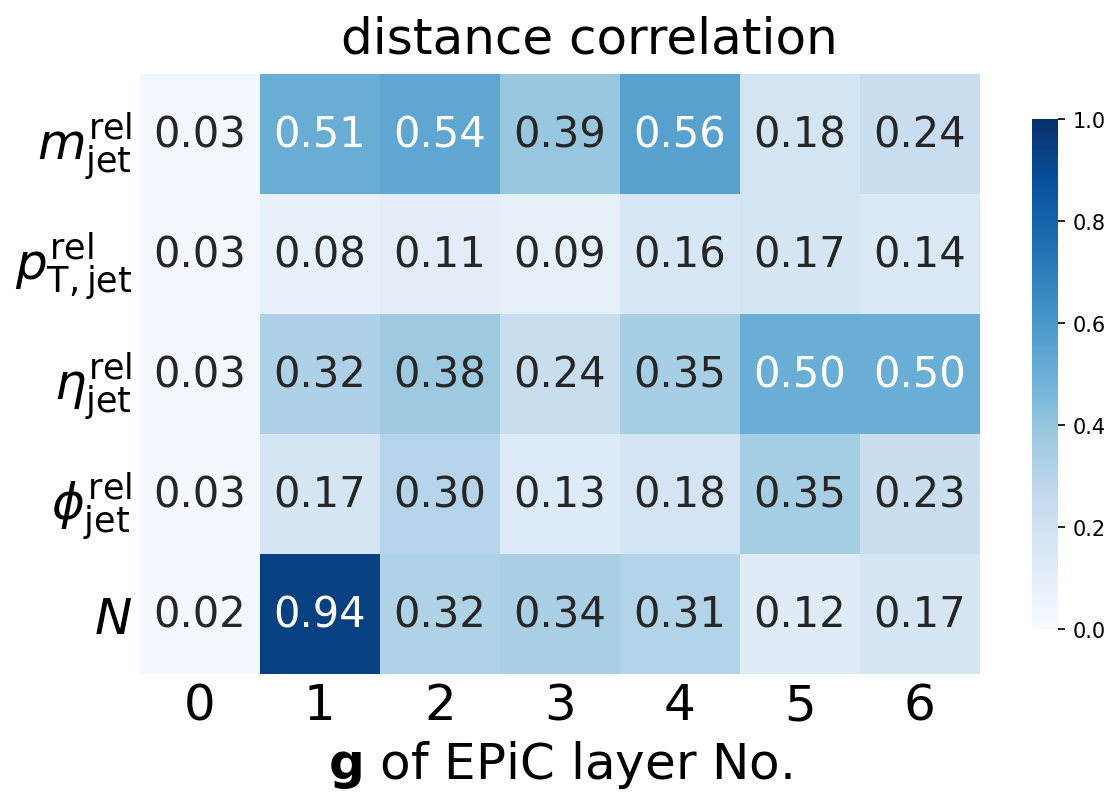

In [400]:
# plot heatmap
# plt.rcParams.update(
#     {
#         "text.usetex": True,
#         "text.latex.preamble": r"\usepackage{amsmath}",
#     }
# )

correlations = pd.DataFrame(mat[:,1:], index=names_list)    # NOT INCLUDING ORIGINAL NOISE VECTOR

fig_cor = plt.figure(figsize=(10,10), dpi=150)
ax_cor = fig_cor.add_subplot(1,1,1)
plt.gcf().subplots_adjust(left=0.2, bottom=0.2)
ticks_y = correlations.index

g = sns_plot = sns.heatmap((correlations),
    xticklabels=correlations.columns,
    yticklabels=ticks_y,
    cmap=sns.color_palette("Blues", as_cmap=True), cbar_kws={"shrink": .5},
    annot=True, ax=ax_cor, vmin=0, vmax=1, 
    annot_kws={"size": 20}, fmt=".2f", square=True, cbar=True, linewidths=0, linecolor='black'
    )

g.tick_params(axis='both', which='both', length=0)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 24, rotation='horizontal')
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 24, rotation='horizontal')
g.set_xlabel(r'$\mathbf{g}$ of EPiC layer No.', fontsize = 24)

#ax_cor.patch.set_facecolor('whitesmoke')
#fig_cor.patch.set_facecolor('None')

fig_cor.suptitle(r'distance correlation', fontsize=24, y=0.78)

if save_plots:
    def create_output_folder(outpath):
        if not os.path.exists(outpath):
            os.makedirs(outpath)
            print("ouput directory created in ", outpath)
    create_output_folder(pdf_folder)
    fig_cor.savefig(pdf_folder+'distance_corr.pdf', bbox_inches='tight', dpi=300)
    print('plot saved')

fig_cor.show()

#print('Model {}: '.format(scan_x_list[j]),sortmask[0:lat])

In [401]:
np.corrcoef(reco_ms, reco_efps[...,4])

array([[1.        , 0.90129271],
       [0.90129271, 1.        ]])

In [402]:
np.corrcoef(data_mults, data_ms)

array([[1.        , 0.48086755],
       [0.48086755, 1.        ]])